In [1]:
import os
import numpy as np
import pingouin as pg
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import correlation
from torch.utils.data import DataLoader, Dataset, Subset
from nilearn.connectome import sym_matrix_to_vec
from ContModeling.helper_classes import MatData
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.metrics import (PredictionErrorDisplay, 
                             make_scorer,
                             mean_absolute_percentage_error,
                             mean_squared_error)
from sklearn.model_selection import cross_val_score, ShuffleSplit
import xarray as xr

In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'

In [20]:
def custom_corr(y, y_pred):
    corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)
    return corr

In [21]:
corr_scorer = make_scorer(custom_corr)
mape_scorer = make_scorer(mean_absolute_percentage_error)
mse_scorer = make_scorer(mean_squared_error)

In [22]:
dataset_name = "hcp"
domain = "cog"
dataset_path = f"data/{dataset_name}_400parcels.nc"

In [23]:
dataset = xr.open_dataset(dataset_path)

In [ ]:
mode = "shuffle"
prediction_type = "multivar"

if mode =="cv":
    exp_name = f"5foldcv_redmat_enc_{dataset_name}_{prediction_type}_{domain}"
else:
    exp_name = f"shuffle_redmat_enc_{dataset_name}_{prediction_type}_{domain}"
    
root = '.'
exp_dir = f"{root}/results/{exp_name}"
embedding_dir = f"{exp_dir}/embeddings"

### Corr Across folds and targets

In [25]:
target_dict_hcp = {
    "PicVocab_AgeAdj": "NIHTB Vocabulary (picture matching)",
    "ReadEng_AgeAdj": "NIHTB Reading (pronunciation)",
    "WM_Task_2bk_Acc": "Working Memory (2-back)",
    "Relational_Task_Acc": "Relational processing",
    "Language_Task_Story_Acc": "Story comprehension",
    "PMAT24_A_CR": "Fluid Intelligence (PMAT)",
    "VSPLOT_TC": "Spatial orientation",  #???
    "CardSort_AgeAdj": "NIHTB Cognitive Flexibility (DCCS)",
    "PMAT24_A_CR": "Fluid Intelligence (Penn Progressive Matrices)",
    "ProcSpeed_AgeAdj": "NIHTB Processing Speed",
    "CogFluidComp_AgeAdj":"NIHTB Cognition Fluid",
    "CogTotalComp_AgeAdj":"NIHTB Cognition Total",
    "CogCrystalComp_AgeAdj":"NIHTB Cognition Crystallized",
    "ListSort_AgeAdj": "NIHTB Working Memory (list sorting)",
    "Language_Task_Math_Acc": "Arithmetic", # ???
    "PicSeq_AgeAdj": "NIHTB Visual Episodic Memory",
    "SCPT_SPEC": "Sustained attention (Spec.)",
    "Flanker_AgeAdj": "NIHTB Inhibition (Flanker Task)",

    "AngAffect_Unadj": "NIHTB Anger",
    "AngHostil_Unadj": "NIHTB Hostility & Cynicism",
    "AngAggr_Unadj": "NIHTB Physical Aggression",
    "FearAffect_Unadj": "NIHTB Fear",
    "FearSomat_Unadj": "NIHTB Somatic Arousal",
    "Sadness_Unadj": "NIHTB Sadness",
    "LifeSatisf_Unadj": "NIHTB Life Satisfaction",
    "MeanPurp_Unadj": "NIHTB Meaning and Purpose",
    "PosAffect_Unadj": "NIHTB Positive Affect",
    "Friendship_Unadj": "NIHTB Friendship",
    "Loneliness_Unadj": "NIHTB Loneliness",
    "PercHostil_Unadj": "NIHTB Perceived Hostility",
    "PercReject_Unadj": "NIHTB Perceived Rejection",
    "EmotSupp_Unadj": "NIHTB Emotional Support",
    "InstruSupp_Unadj": "NIHTB Instrumental Support",
    "PercStress_Unadj": "NIHTB Perceived Stress",
    "SelfEff_Unadj": "NIHTB Self-Efficacy",
    
    "Emotion_Task_Face_Acc": "Emotional Face Matching",
    "IWRD_TOT": "Verbal Episodic Memory",
    "Dexterity_AgeAdj": "Manual dexterity",
    "ER40_CR": "Emotion recognition - Total",
    "ER40SAD": "Emotion recognition - Sad",
    "ER40ANG": "Emotion recognition - Angry",
    ### SOCIAL COGNITION - INTERACTION ??????
    "ER40NOE": "Emotion recognition - Neutral",
    "MMSE_Score": "Cognitive status (MMSE)",
    "ER40HAP": "Emotion recognition - Happy",
    "SCPT_SEN": "Sustained attention (Sens.)",
    "Social_Task_Perc_Random": "Social cognition (Random)",
    "ER40FEAR": "Emotion recognition - Fear"
}

target_dict_abcd = {
    'cbcl_scr_syn_anxdep_r': 'CBCL Anxiety/Depression',
    'cbcl_scr_syn_anxdep_t': 'CBCL Anxiety/Depression',
    'cbcl_scr_syn_withdep_r': 'CBCL Withdrawn/Depressed',
    'cbcl_scr_syn_withdep_t': 'CBCL Withdrawn/Depressed',
    'cbcl_scr_syn_somatic_r': 'CBCL Somatic Complaints',
    'cbcl_scr_syn_somatic_t': 'CBCL Somatic Complaints',
    'cbcl_scr_syn_social_r': 'CBCL Social Problems',
    'cbcl_scr_syn_social_t': 'CBCL Social Problems',
    'cbcl_scr_syn_thought_r': 'CBCL Thought Problems',
    'cbcl_scr_syn_thought_t': 'CBCL Thought Problems',
    'cbcl_scr_syn_attention_r': 'CBCL Attention Problems',
    'cbcl_scr_syn_attention_t': 'CBCL Attention Problems',
    'cbcl_scr_syn_rulebreak_r': 'CBCL Rule-Breaking Behavior',
    'cbcl_scr_syn_rulebreak_t': 'CBCL Rule-Breaking Behavior',   
    'cbcl_scr_syn_aggressive_r': 'CBCL Aggressive Behavior',
    'cbcl_scr_syn_aggressive_t': 'CBCL Aggressive Behavior',
    'cbcl_scr_syn_internal_r': 'CBCL Internalizing Problems',
    'cbcl_scr_syn_internal_t': 'CBCL Internalizing Problems',
    'cbcl_scr_syn_external_r': 'CBCL Externalizing Problems',
    'cbcl_scr_syn_external_t': 'CBCL Externalizing Problems',
    'cbcl_scr_syn_totprob_r': 'CBCL Total Problems',
    'cbcl_scr_syn_totprob_t': 'CBCL Total Problems',
    'cbcl_scr_07_sct_r': 'CBCL Social Competence',
    'cbcl_scr_07_sct_t': 'CBCL Social Competence',
    'cbcl_scr_07_ocd_r': 'CBCL Obsessive-Compulsive Disorder',
    'cbcl_scr_07_ocd_t': 'CBCL Obsessive-Compulsive Disorder',
    'cbcl_scr_07_stress_r': 'CBCL Stress, raw value',
    'cbcl_scr_07_stress_t': 'CBCL Stress, t value',
    'nihtbx_picvocab_uncorrected': "Vocabulary (picture matching), uncorrected",
    'nihtbx_flanker_uncorrected': "Inhibition (Flanker Task), uncorrected",
    'nihtbx_list_uncorrected': "Working Memory (list sorting), uncorrected",
    'nihtbx_cardsort_uncorrected': "Cognitive Flexibility (DCCS), uncorrected",
    'nihtbx_pattern_uncorrected': "Processing Speed, uncorrected",
    'nihtbx_reading_uncorrected': "Reading (pronunciation), uncorrected",
    'nihtbx_fluidcomp_uncorrected': "Cognition Fluid Composite Score, uncorrected",
    'nihtbx_cryst_uncorrected': "Cognition Crystallized Composite Score, uncorrected",
    'nihtbx_totalcomp_uncorrected': "Cognition Total Composite Score, uncorrected",
    'pea_wiscv_trs': "WISC-V Total Raw Score",
    'pea_wiscv_tss': "WISC-V Total Score",
    'nihtbx_picvocab_agecorrected': "NIHTB Vocabulary (picture matching)",
    'nihtbx_flanker_agecorrected': "NIHTB Inhibition (Flanker Task)",
    'nihtbx_list_agecorrected': "NIHTB Working Memory (list sorting)",
    'nihtbx_cardsort_agecorrected': "NIHTB Cognitive Flexibility (DCCS)",
    'nihtbx_pattern_agecorrected': "NIHTB Processing Speed",
    'nihtbx_picture_agecorrected': "NIHTB Visual Episodic Memory",
    'nihtbx_reading_agecorrected': "NIHTB Reading (pronunciation)",
    'nihtbx_fluidcomp_agecorrected': "NIHTB Cognition Fluid",
    'nihtbx_cryst_agecorrected': "NIHTB Cognition Crystallized",
    'nihtbx_totalcomp_agecorrected': "NIHTB Cognition Total",
    'nihtbx_picture_uncorrected': "NIHTB Visual Episodic Memory, uncorrected",
}

In [26]:
if dataset_name == "abcd":
    target_dict = target_dict_abcd
elif dataset_name == "hcp":
    target_dict = target_dict_hcp

In [27]:
predictions = pd.read_csv(f'{exp_dir}/pred_results.csv')

In [28]:
exp_dir

'./results/shuffle_redmat_enc_hcp_multivar_cog'

In [13]:
predictions_cog

NameError: name 'predictions_cog' is not defined

In [ ]:
predictions_cog = pd.read_csv(f'./results/shuffle_redmat_enc_hcp_multivar_cog/pred_results.csv')
predictions_psy = pd.read_csv(f'./results/shuffle_redmat_enc_hcp_multivar_psy/pred_results.csv')
predictions = pd.concat([predictions_cog, predictions_psy])
predictions[predictions["seed"]==54]

,train_ratio,seed,dataset,PicVocab_AgeAdj,ReadEng_AgeAdj,CogFluidComp_AgeAdj,CogTotalComp_AgeAdj,CogCrystalComp_AgeAdj,CardSort_AgeAdj,ListSort_AgeAdj,...,MeanPurp_Unadj_pred,PosAffect_Unadj_pred,Friendship_Unadj_pred,Loneliness_Unadj_pred,PercHostil_Unadj_pred,PercReject_Unadj_pred,EmotSupp_Unadj_pred,InstruSupp_Unadj_pred,PercStress_Unadj_pred,SelfEff_Unadj_pred
2024,1.0,54,train,0.567561,0.616705,0.087871,0.333905,0.581186,0.399060,0.538319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025,1.0,54,train,0.574433,0.855249,0.400801,0.672953,0.703021,0.606723,0.538319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026,1.0,54,train,0.524602,0.621077,0.768557,0.774861,0.561972,0.857943,0.775783,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2027,1.0,54,train,0.316645,0.778109,0.534485,0.605444,0.534762,0.766311,0.526681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2028,1.0,54,train,0.407844,0.629356,0.302416,0.410737,0.484007,0.683716,0.526681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,1.0,54,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.071525,-0.081151,0.066567,0.022027,-0.052407,-0.045056,0.151892,0.087493,0.029643,-0.001850
1023,1.0,54,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.060511,-0.090448,0.056875,0.013319,-0.039460,-0.051696,0.165080,0.079000,0.031957,0.006468
1024,1.0,54,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.065395,-0.067125,0.028466,-0.007906,-0.054712,-0.036051,0.138772,0.080757,0.025435,0.004175
1025,1.0,54,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.073251,-0.071274,0.033516,0.004622,-0.045384,-0.039722,0.142694,0.067645,0.033038,0.004692


In [ ]:

predictions_cog_long = predictions_cog.melt(id_vars=['seed',
                        'dataset',
                        'indices',
                        ],
                var_name="target",
                value_vars=['PicVocab_AgeAdj',
                            'ReadEng_AgeAdj',
                            'CogFluidComp_AgeAdj',
                            'CogTotalComp_AgeAdj',
                            'CogCrystalComp_AgeAdj',
                            'CardSort_AgeAdj',
                            'ListSort_AgeAdj',
                            'ProcSpeed_AgeAdj',
                            'PicSeq_AgeAdj',
                            'Flanker_AgeAdj'])


predictions_psy_long = predictions_psy.melt(id_vars=['seed',
                        'dataset',
                        'indices',
                        ],
                var_name="target",
                value_vars=['AngAffect_Unadj',
                            'AngHostil_Unadj',
                            'AngAggr_Unadj',
                            'FearAffect_Unadj',
                            'FearSomat_Unadj',
                            'Sadness_Unadj',
                            'LifeSatisf_Unadj',
                            'MeanPurp_Unadj',
                            'PosAffect_Unadj',
                            'Friendship_Unadj',
                            'Loneliness_Unadj',
                            'PercHostil_Unadj',
                            'PercReject_Unadj',
                            'EmotSupp_Unadj',
                            'InstruSupp_Unadj',
                            'PercStress_Unadj',
                            'SelfEff_Unadj'])



In [14]:
predictions_df = pd.concat([predictions_cog_long, predictions_psy_long])
predictions_df[(predictions_df["seed"]==54) & (predictions_df["dataset"]=="test")].to_csv(f'./target_values.csv')

NameError: name 'predictions_cog_long' is not defined

In [112]:
predictions_cog[(predictions_cog["seed"]==42) & (predictions_cog["dataset"]=="train") & (predictions_cog["indices"]==578)]

,train_ratio,seed,dataset,PicVocab_AgeAdj,ReadEng_AgeAdj,CogFluidComp_AgeAdj,CogTotalComp_AgeAdj,CogCrystalComp_AgeAdj,CardSort_AgeAdj,ListSort_AgeAdj,...,PicVocab_AgeAdj_pred,ReadEng_AgeAdj_pred,CogFluidComp_AgeAdj_pred,CogTotalComp_AgeAdj_pred,CogCrystalComp_AgeAdj_pred,CardSort_AgeAdj_pred,ListSort_AgeAdj_pred,ProcSpeed_AgeAdj_pred,PicSeq_AgeAdj_pred,Flanker_AgeAdj_pred
0,1.0,42,train,0.436012,0.758682,0.643351,0.700489,0.578466,0.7823,0.464405,...,-0.050902,-0.083725,0.082264,-0.012498,0.094538,0.078539,0.026256,0.03872,-0.007074,-0.007862


In [111]:
predictions_cog["indices"]

0         578
1         645
2         910
3         475
4          64
         ... 
10115     588
10116     805
10117     734
10118     834
10119    1015
Name: indices, Length: 10120, dtype: int64

In [103]:
predictions_long

,seed,dataset,indices,target,value
0,42,train,578,PicVocab_AgeAdj,0.436012
1,42,train,645,PicVocab_AgeAdj,0.355299
2,42,train,910,PicVocab_AgeAdj,0.561696
3,42,train,475,PicVocab_AgeAdj,0.245595
4,42,train,64,PicVocab_AgeAdj,0.502609
...,...,...,...,...,...
101195,340,test,588,Flanker_AgeAdj,0.412772
101196,340,test,805,Flanker_AgeAdj,0.199637
101197,340,test,734,Flanker_AgeAdj,0.696817
101198,340,test,834,Flanker_AgeAdj,0.400483


In [63]:
def fit_estimator(X_train,
                  y_train,
                  model="ridge"):
        
    if model == "ridge":
        estimator = Ridge(alpha=1.0)
    elif model == "krr":
        estimator = KernelRidge()
        estimator = GridSearchCV(
                    estimator=estimator, param_grid={
                        "alpha": [0, 1e-5, 1e-3, 1e-3, 4e-3, 7e-3, 1, 1.5, 2, 4, 5, 10, 15, 20],
                        "kernel": ['linear', 'rbf'],
                        
                    },
                )
    fitted_estimator = estimator.fit(X_train, y_train)

    return fitted_estimator

In [64]:
def get_perf_df(train,
                y,
                y_pred,
                target,
                train_ratio,
                run_type,
                run_id,
                target_dict,
                exp_dir = None,
                df_filename = None,
                save_pred=False,
                save_df = False):

    target_run_perf = {}

    if train:
        data = "train"
    else:
        data = "test"

    if save_pred:
        np.save(f"{exp_dir}/ridge_y_pred_{target}_{run_type}{run_id}_train_ratio{train_ratio}_{data}.npy", y_pred)

    corr = custom_corr(y, y_pred)


    target_run_perf["target"] = target_dict[target]
    target_run_perf[f"{data}_corr"] = corr
    target_run_perf[f"{data}_mape"] = np.mean(100*np.abs((y-y_pred)/(y + 1e-100)))
    # target_run_perf[f"{data}_mse"] = mean_squared_error(y, y_pred)
    target_run_perf["train_ratio"] = train_ratio
    target_run_perf[run_type] = run_id
    # target_run_perf = pd.DataFrame(target_run_perf)

    # if save_df:
    #     save_dir = os.path.join(exp_dir, "perm_test_results")
    #     save_dir = os.makedirs(save_dir, exist_ok=True)
    #     target_run_perf.to_csv(f"{save_dir}/{df_filename}_{target}_{run_type}{run_id}_train_ratio{train_ratio}_{data}.csv")
    
    return target_run_perf

In [65]:
def perm_test(X_train,
              X_test,
              cl_predictions_df,
              target,
              exp_dir,
              run_type,
              run_id,
              n_iter=1000):
    
    perf_dfs = []

    y_train = cl_predictions_df[(cl_predictions_df["dataset"] == "train") & (cl_predictions_df["train_ratio"] == 1.0) & (cl_predictions_df[run_type] == run_id)][target].values
    y_test = cl_predictions_df[(cl_predictions_df["dataset"] == "test") & (cl_predictions_df["train_ratio"] == 1.0) & (cl_predictions_df[run_type] == run_id)][target].values

    for perm in tqdm(range(n_iter)):
        y_train_perm = np.random.permutation(y_train)

        fitted_estimator = fit_estimator(
            X_train,
            y_train_perm)
        
        y_test_perm_pred = fitted_estimator.predict(X_test)

        perf_df = get_perf_df(
            False,
            y_test,
            y_test_perm_pred,
            target,
            1.0,
            run_type,
            run_id,
            target_dict,
            exp_dir,
            df_filename = f"ridge_perm_{perm}",
            save_pred=False,
            save_df=False)
        
        perf_df["perm_inter"] = perm
        perf_dfs.append(perf_df)

    
    perf = pd.DataFrame(perf_dfs)

    return perf

        

In [ ]:
from sklearn.utils import check_random_state
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer


def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100


def freedman_lane_permutation_test(
    X_train,
    y_train,
    X_test,
    y_test,
    nuisance_idx,
    age_idx,
    sex_idx,
    n_permutations=1000,
    alpha=1.0,
    random_state=None,
):
    """
    Performs Freedman–Lane permutation test with preprocessing and correlation + MAPE as metrics.

    Parameters
    ----------
    X_train, X_test : ndarray (n_samples, n_features)
        Full design matrix (including nuisance + effect variables).
    y_train, y_test : ndarray (n_samples,)
        Response variable.
    nuisance_idx : list of int
        Indices of nuisance covariates in the design matrix.
    age_idx : int
        Index of the "age" variable (to be MinMax-scaled).
    sex_idx : int
        Index of the "sex" variable (to be one-hot encoded).
    n_permutations : int
        Number of permutations.
    alpha : float
        Ridge regularization strength.
    random_state : int or None
        Reproducibility.

    Returns
    -------
    p_corr, p_mape : float
        P-values for correlation and MAPE.
    T0_corr, T0_mape : float
        Observed test statistics.
    T_star_corr, T_star_mape : ndarray
        Null distributions of test statistics.
    """
    rng = check_random_state(random_state)

    # --- Define preprocessing pipeline ---
    n_features = X_train.shape[1]
    passthrough_idx = [i for i in range(n_features) if i not in [age_idx, sex_idx]]

    preprocessor = ColumnTransformer(transformers=[
        ("scale_age", MinMaxScaler(), [age_idx]),
        ("encode_sex", OneHotEncoder(sparse_output=False, drop='if_binary'), [sex_idx]),
        ("passthrough", FunctionTransformer(), passthrough_idx),
    ])

    full_pipeline = Pipeline([
        ("preproc", preprocessor),
    ])

    # Transform both train and test sets
    X_train_proc = full_pipeline.fit_transform(X_train)
    X_test_proc = full_pipeline.transform(X_test)

    # --- Build index maps for nuisance/effects AFTER transformation ---
    n_sex_levels = full_pipeline.named_steps['preproc'].named_transformers_['encode_sex'].categories_[0].shape[0]
    new_feature_order = (
        [0] +                         # age (scaled)
        list(range(1, 1 + n_sex_levels)) +  # one-hot sex
        list(range(1 + n_sex_levels, X_train_proc.shape[1]))  # passthrough
    )

    # Adjust nuisance_idx to new transformed space
    transformed_nuisance_idx = []
    for i in nuisance_idx:
        if i == age_idx:
            transformed_nuisance_idx.append(0)
        elif i == sex_idx:
            transformed_nuisance_idx.extend(range(1, 1 + n_sex_levels))
        else:
            # Shift passthrough indices depending on location
            offset = passthrough_idx.index(i)
            transformed_nuisance_idx.append(1 + n_sex_levels + offset)

    all_idx = np.arange(X_train_proc.shape[1])
    effect_idx = np.setdiff1d(all_idx, transformed_nuisance_idx)

    # Step 1: Fit full model
    full_model = Ridge(alpha=alpha)
    full_model.fit(X_train_proc, y_train)
    y_pred = full_model.predict(X_test_proc)

    T0_corr = pearsonr(y_test, y_pred)[0]
    T0_mape = mean_absolute_percentage_error(y_test, y_pred)

    # Step 2: Fit reduced model on nuisance variables
    Z_train = X_train_proc[:, transformed_nuisance_idx]
    Z_test = X_test_proc[:, transformed_nuisance_idx]
    reduced_model = Ridge(alpha=alpha)
    reduced_model.fit(Z_train, y_train)
    y_hat_Z = reduced_model.predict(Z_train)
    eps_Z = y_train - y_hat_Z

    T_star_corr = []
    T_star_mape = []

    for _ in range(n_permutations):
        # Step 3: Permute residuals
        perm = rng.permutation(len(eps_Z))
        y_star = y_hat_Z + eps_Z[perm]

        # Step 4: Fit full model on permuted data
        model_star = Ridge(alpha=alpha)
        model_star.fit(X_train_proc, y_star)
        y_star_pred = model_star.predict(X_test_proc)

        T_star_corr.append(pearsonr(y_test, y_star_pred)[0])
        T_star_mape.append(mean_absolute_percentage_error(y_test, y_star_pred))

    T_star_corr = np.array(T_star_corr)
    T_star_mape = np.array(T_star_mape)

    p_corr = np.mean(T_star_corr >= T0_corr)
    p_mape = np.mean(T_star_mape <= T0_mape)

    return p_corr, p_mape, T0_corr, T0_mape, T_star_corr, T_star_mape


In [ ]:
if domain == "cog":
    predictions_long = predictions.melt(id_vars=['seed',
                            'dataset',
                            'indices',
                            ],
                    var_name="target",
                    value_vars=['PicVocab_AgeAdj',
                                'ReadEng_AgeAdj',
                                'CogFluidComp_AgeAdj',
                                'CogTotalComp_AgeAdj',
                                'CogCrystalComp_AgeAdj',
                                'CardSort_AgeAdj',
                                'ListSort_AgeAdj',
                                'ProcSpeed_AgeAdj',
                                'PicSeq_AgeAdj',
                                'Flanker_AgeAdj'])


### Permutation test

In [54]:
# def compute_perf(fitted_estimator, X, y):
#     y_pred = fitted_estimator.predict(X)
#     corr = custom_corr(y, y_pred)
#     mape = np.median(100*np.abs((y-y_pred)/y))
#     return corr, mape


In [30]:
if mode == "cv":
    test_type = "validation"
    run_type = "fold"
    runs = np.arange(5)
else:
    test_type = "test"
    run_type = "seed"
    runs = [1001, 42, 54, 90, 101, 80, 422, 142, 128, 340]

In [31]:
embedding_dir = f"{exp_dir}/embeddings"
train_ratio = 1.0
perm_model_perf_df = []

for run_id in tqdm(runs):
    X_train = np.load(f"{embedding_dir}/joint_embeddings_{run_type}{run_id}_train_ratio{train_ratio}_train.npy")
    X_test = np.load(f"{embedding_dir}/joint_embeddings_{run_type}{run_id}_train_ratio{train_ratio}_{test_type}.npy")
    for target in tqdm(target_dict.keys()):
        if target in predictions.columns:
            perm_result=perm_test(
                X_train,
                X_test,
                predictions,
                target,
                exp_dir,
                run_type,
                run_id,
                n_iter=10000   
            )
            perm_model_perf_df.append(perm_result)

perm_model_perf_df = pd.concat(perm_model_perf_df)

  0%|          | 0/10 [00:00<?, ?it/s]


NameError: name 'perm_test' is not defined

In [22]:
save_dir = os.path.join(exp_dir, "perm_test_results")
os.makedirs(save_dir, exist_ok=True)
perm_model_perf_df.to_csv(f"{save_dir}/perm_test_results_test_mape.csv")

In [33]:
perm_model_perf_df

,target,test_corr,median_test_mape,train_ratio,seed,perm_inter
0,NIHTB Vocabulary (picture matching),0.081814,10.399870,1.0,1001,0
1,NIHTB Vocabulary (picture matching),0.081814,34.921827,1.0,1001,0
2,NIHTB Vocabulary (picture matching),0.081814,32.906220,1.0,1001,0
3,NIHTB Vocabulary (picture matching),0.081814,41.504404,1.0,1001,0
4,NIHTB Vocabulary (picture matching),0.081814,46.819520,1.0,1001,0
...,...,...,...,...,...,...
298,NIHTB Inhibition (Flanker Task),0.036062,51.072105,1.0,340,9999
299,NIHTB Inhibition (Flanker Task),0.036062,179.718583,1.0,340,9999
300,NIHTB Inhibition (Flanker Task),0.036062,15.835935,1.0,340,9999
301,NIHTB Inhibition (Flanker Task),0.036062,40.863926,1.0,340,9999


In [118]:
def sig_level_corr(x):
    return np.percentile(x, 97.5)

def sig_level_err(x):
    return np.percentile(x, 2.5)

def mean_null_dist(x):
    return np.mean(x)

### Fit and test Ridge on embeddings

In [72]:
embedding_dir = f"{exp_dir}/embeddings"
train_ratio = 1.0
model_perf_df = []

for run_id in runs:
    X_train = np.load(f"{embedding_dir}/joint_embeddings_{run_type}{run_id}_train_ratio{train_ratio}_train.npy")
    X_test = np.load(f"{embedding_dir}/joint_embeddings_{run_type}{run_id}_train_ratio{train_ratio}_{test_type}.npy")

    for target in target_dict.keys():
        if target in predictions.columns:
            y_train = predictions[(predictions["dataset"] == "train") & (predictions["train_ratio"] == 1.0) & (predictions[run_type] == run_id)][target].values
            y_test = predictions[(predictions["dataset"] == "test") & (predictions["train_ratio"] == 1.0) & (predictions[run_type] == run_id)][target].values
            fitted_estimator = fit_estimator(X_train,
                                             y_train
            )
            y_test_pred = fitted_estimator.predict(X_test)

            perf_df = get_perf_df(
                False,
                y_test,
                y_test_pred,
                target,
                1.0,
                run_type,
                run_id,
                target_dict,
                exp_dir,
                None,
                save_pred=False,
                save_df=False
                )
            model_perf_df.append(perf_df)
            
model_perf_df = pd.DataFrame(model_perf_df)
model_perf_df.to_csv(f"{exp_dir}/ridge_model_perf_mape.csv", index=False)


In [33]:
target

'PicVocab_AgeAdj'

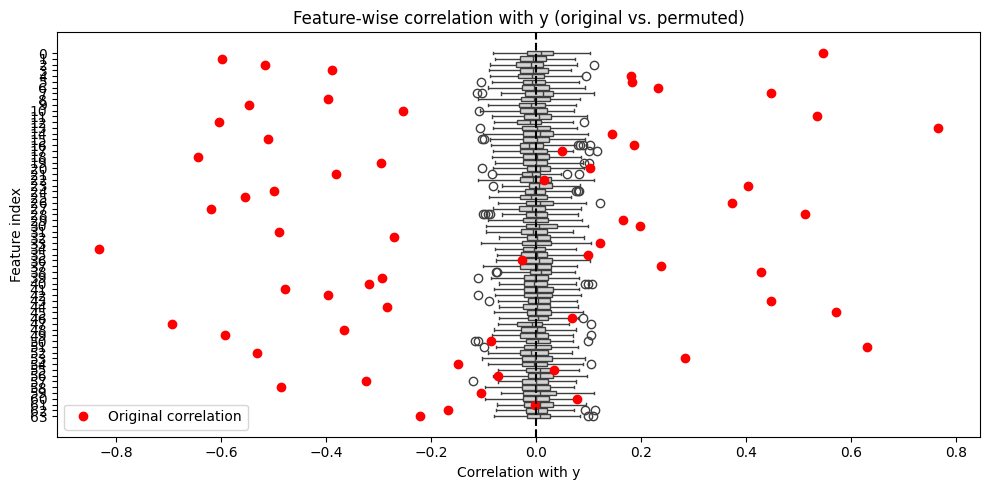

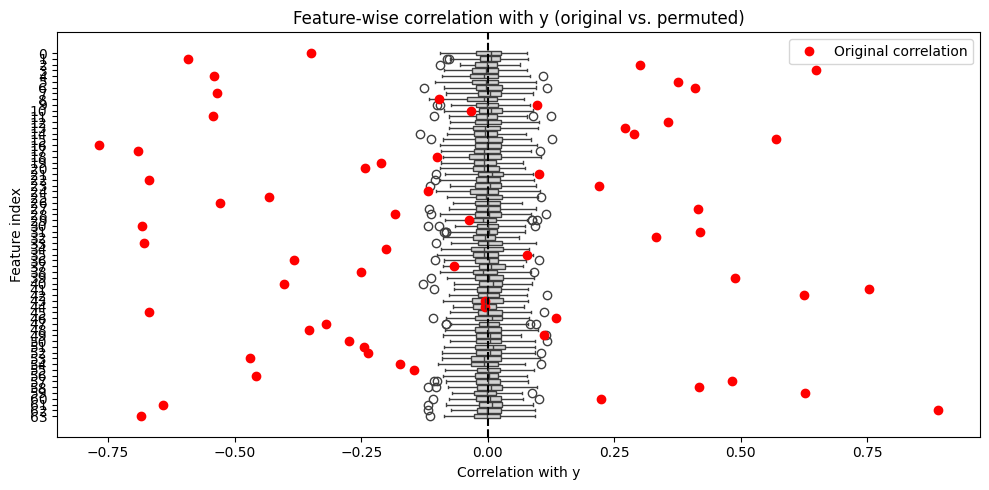

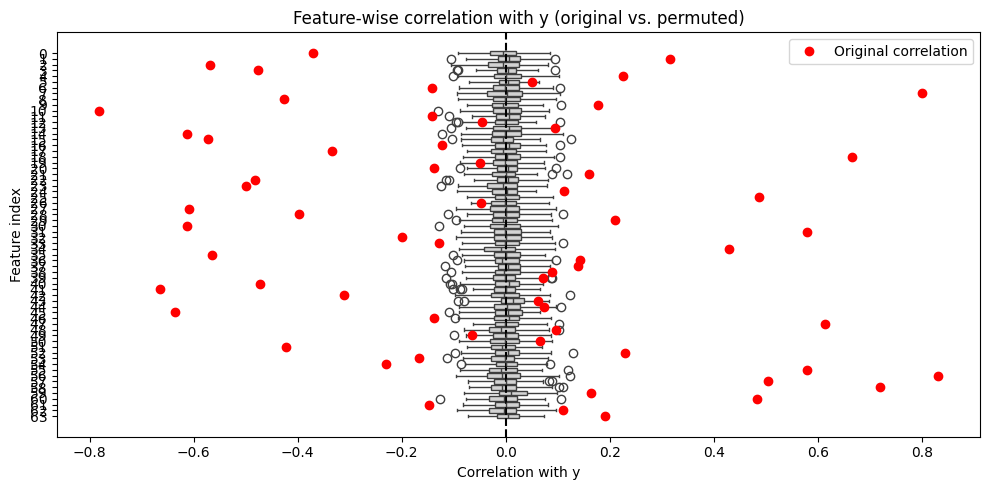

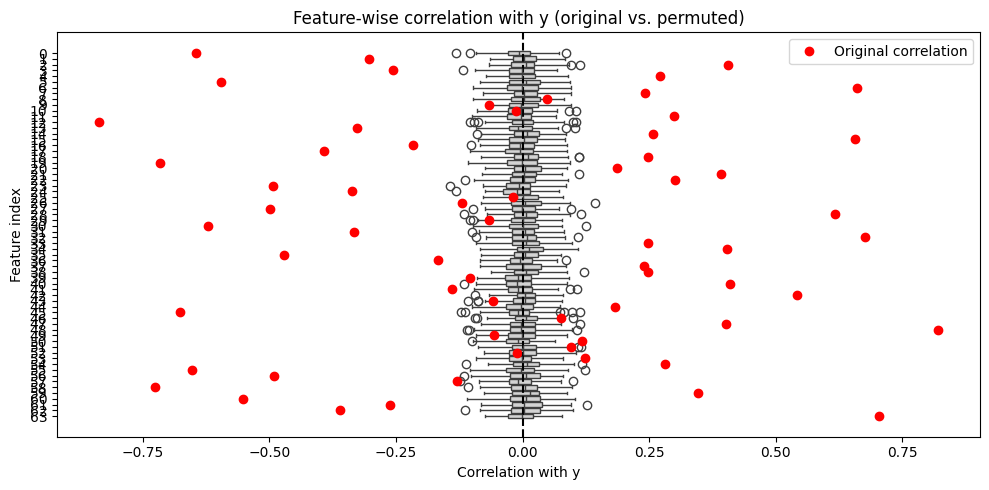

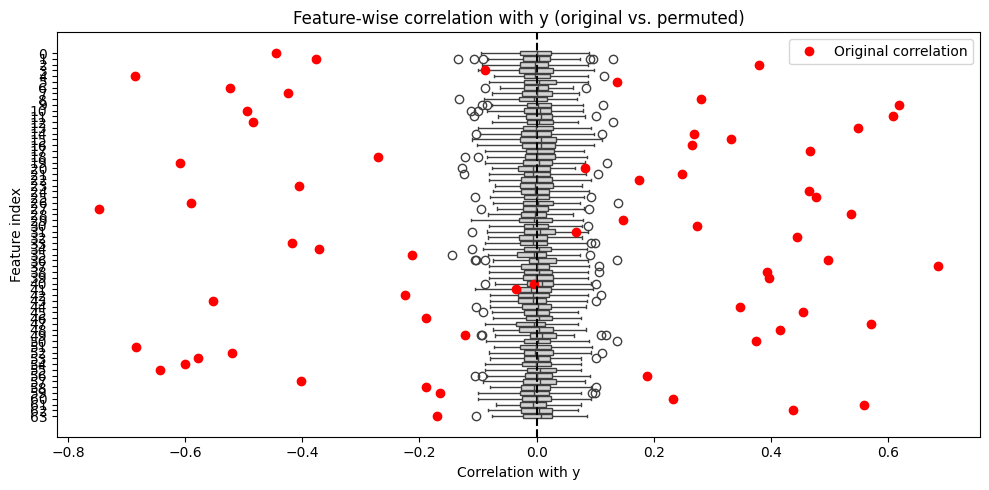

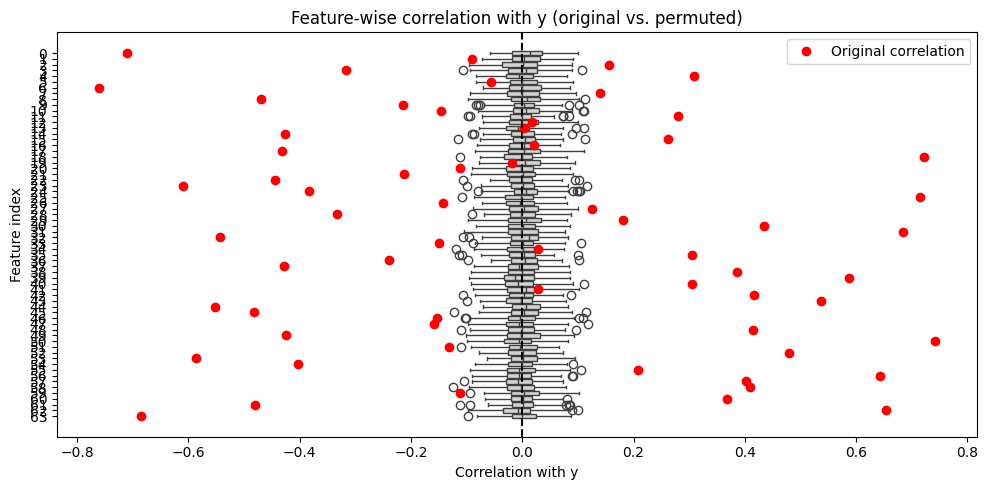

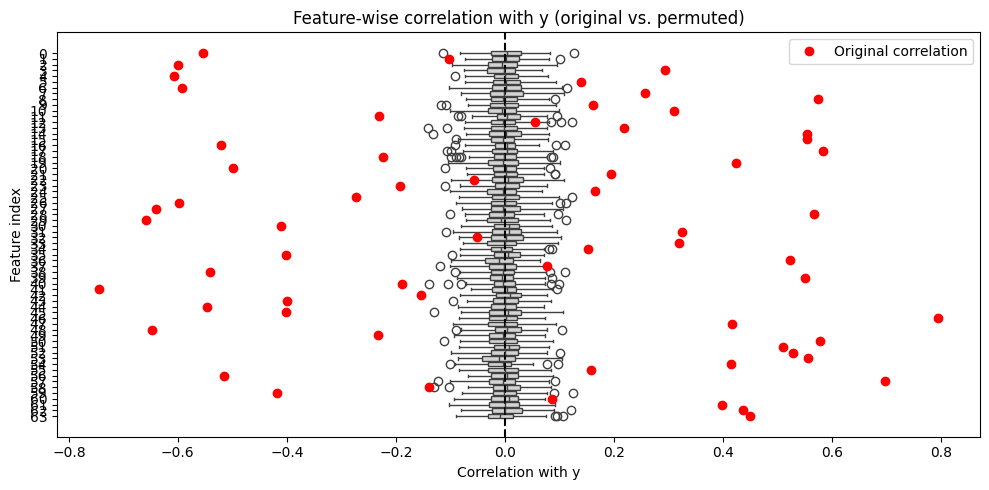

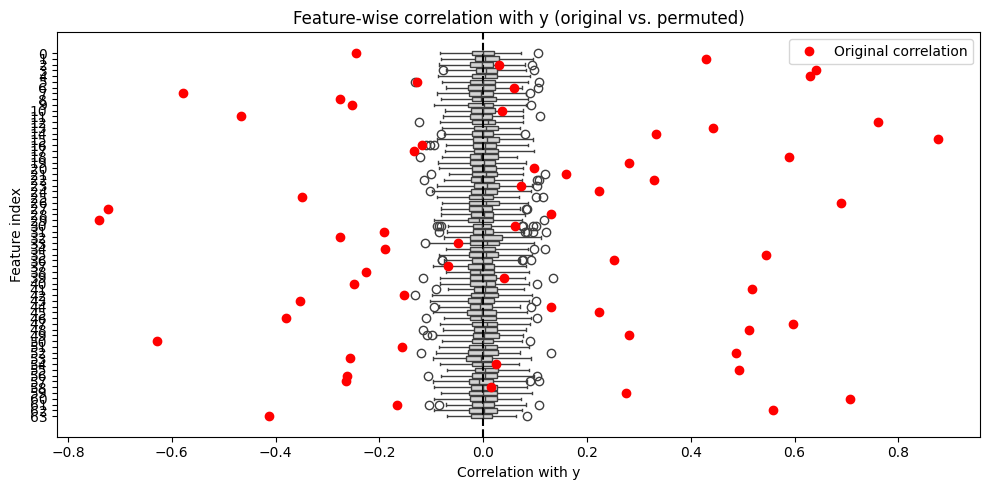

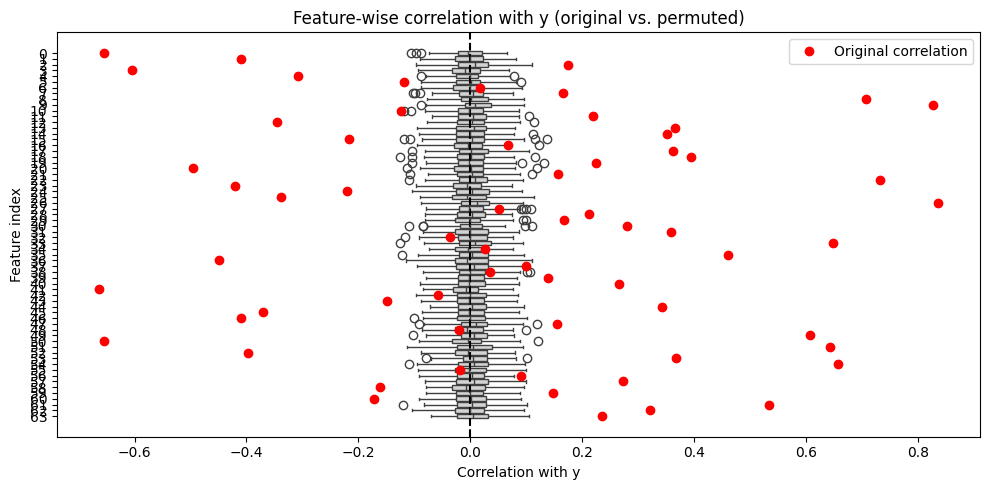

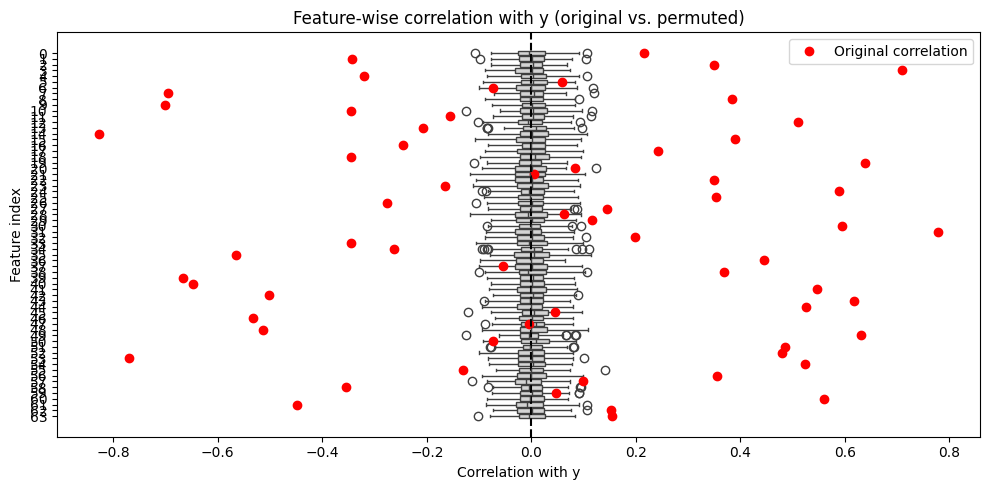

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

embedding_dir = f"{exp_dir}/embeddings"
n_perms = 100

for run_id in runs:
    X_train = np.load(f"{embedding_dir}/joint_embeddings_{run_type}{run_id}_train_ratio{train_ratio}_train.npy")
    y_train = predictions[(predictions["dataset"] == "train") & (predictions["train_ratio"] == 1.0) & (predictions[run_type] == run_id)][target].values
    original_corrs = np.corrcoef(X_train.T, y_train)[-1, :-1]


    permuted_corrs = []
    for _ in range(n_perms):
        y_perm = np.random.permutation(y_train)
        corr = np.corrcoef(X_train.T, y_perm)[-1, :-1]
        permuted_corrs.append(corr)

    permuted_corrs = np.array(permuted_corrs)  # shape (n_perms, n_features)

    # Plot
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=permuted_corrs, orient='h', color='lightgray')
    plt.plot(original_corrs, range(len(original_corrs)), 'ro', label='Original correlation')
    plt.axvline(0, color='black', linestyle='--')
    plt.xlabel('Correlation with y')
    plt.ylabel('Feature index')
    plt.title('Feature-wise correlation with y (original vs. permuted)')
    plt.legend()
    plt.tight_layout()
    plt.show()


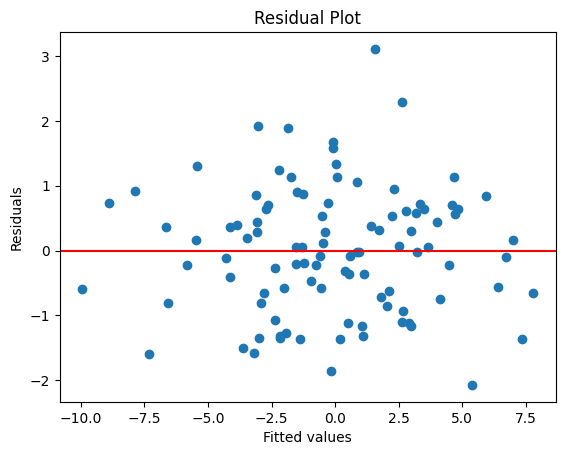

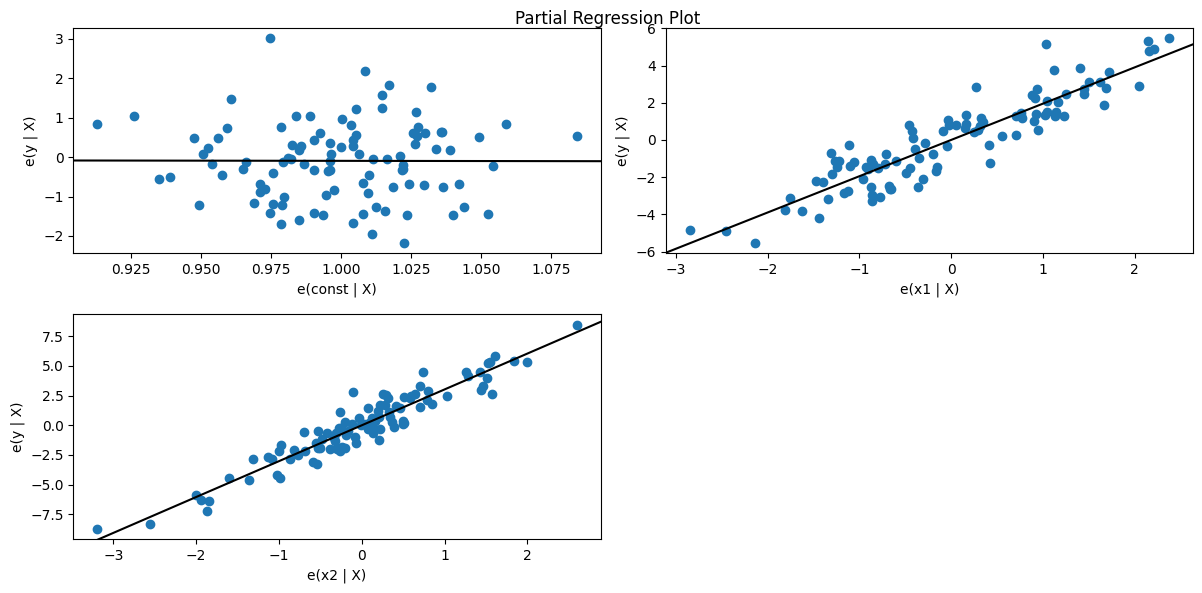

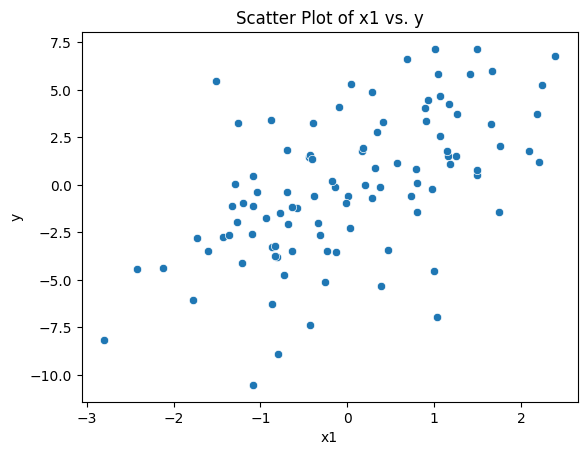

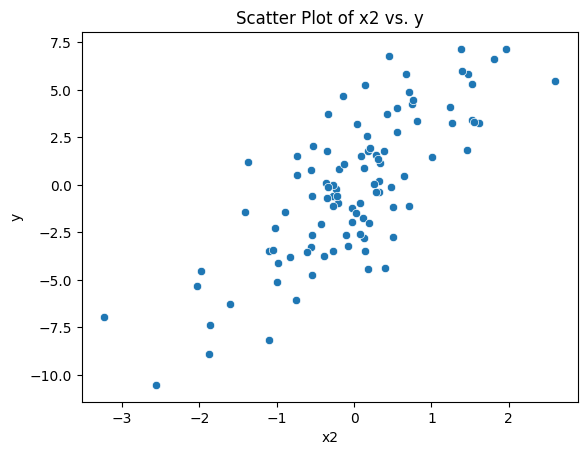

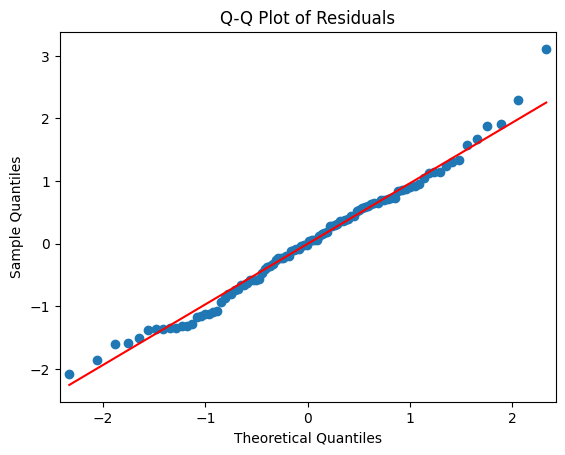

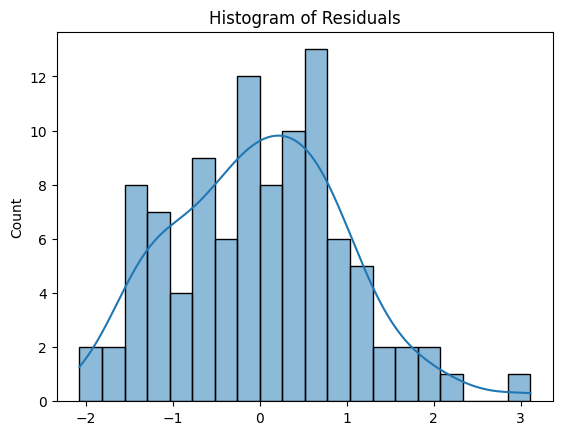

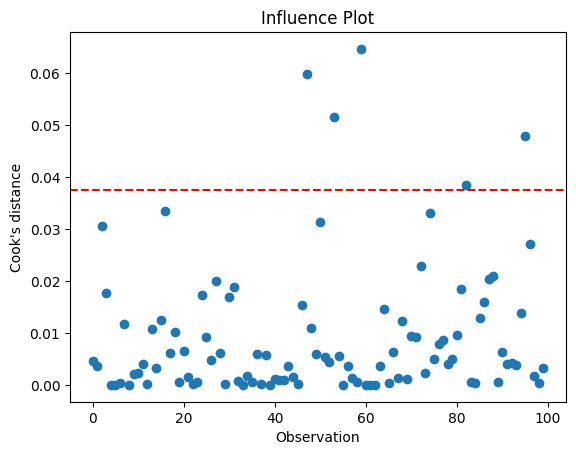

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Example data
np.random.seed(123)
x1 = np.random.normal(loc=0, scale=1, size=100)
x2 = np.random.normal(loc=0, scale=1, size=100)
y = 2 * x1 + 3 * x2 + np.random.normal(loc=0, scale=1, size=100)

# Combine into a DataFrame
df = pd.DataFrame({'y': y, 'x1': x1, 'x2': x2})

# Fit a linear regression model
X = df[['x1', 'x2']]
X = sm.add_constant(X)
model = sm.OLS(df['y'], X).fit()

# Residual plots
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Partial regression plots
fig = plt.figure(figsize=(12, 6))
sm.graphics.plot_partregress_grid(model, fig=fig)
plt.show()

# Scatter plots of predictors vs. target
sns.scatterplot(data=df, x='x1', y='y')
plt.title('Scatter Plot of x1 vs. y')
plt.show()

sns.scatterplot(data=df, x='x2', y='y')
plt.title('Scatter Plot of x2 vs. y')
plt.show()

# Q-Q plot of residuals
sm.qqplot(model.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Histogram of residuals
sns.histplot(model.resid, bins=20, kde=True)
plt.title('Histogram of Residuals')
plt.show()

# Leverage plots
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]
plt.scatter(np.arange(len(cooks_d)), cooks_d)
plt.axhline(y=4*np.mean(cooks_d), color='r', linestyle='--')
plt.xlabel('Observation')
plt.ylabel("Cook's distance")
plt.title('Influence Plot')
plt.show()


In [48]:
cov_X = np.cov(yc, rowvar=False)
fig = plt.figure(figsize=(5, 4))
sns.heatmap(cov_X, cmap='viridis')

ValueError: Must pass 2-d input. shape=()

<Figure size 500x400 with 0 Axes>

<Axes: >

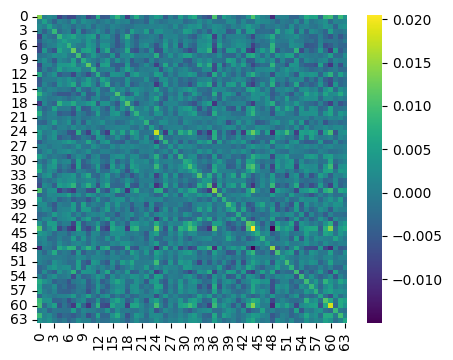

In [47]:
cov_X = np.cov(np.random.permutation(Xc), rowvar=False)
fig = plt.figure(figsize=(5, 4))
sns.heatmap(cov_X, cmap='viridis')


In [17]:
run_id = 54
X_train = np.load(f"{embedding_dir}/joint_embeddings_{run_type}{run_id}_train_ratio{train_ratio}_train.npy")
y_train = predictions[(predictions["dataset"] == "train") & (predictions["train_ratio"] == 1.0) & (predictions[run_type] == run_id)][target].values
original_corrs = np.corrcoef(X_train.T, y_train)[-1, :-1]


NameError: name 'embedding_dir' is not defined

In [73]:
model_perf_df

,target,test_corr,test_mape,train_ratio,seed
0,NIHTB Vocabulary (picture matching),0.480270,1.032846e+99,1.0,1001
1,NIHTB Reading (pronunciation),0.439861,1.128444e+99,1.0,1001
2,NIHTB Cognitive Flexibility (DCCS),0.171467,2.416912e+99,1.0,1001
3,NIHTB Processing Speed,0.066286,2.174654e+99,1.0,1001
4,NIHTB Cognition Fluid,0.287940,7.981062e+98,1.0,1001
...,...,...,...,...,...
95,NIHTB Cognition Total,0.470166,9.652864e+98,1.0,340
96,NIHTB Cognition Crystallized,0.563631,1.043360e+99,1.0,340
97,NIHTB Working Memory (list sorting),0.111814,4.066645e+99,1.0,340
98,NIHTB Visual Episodic Memory,0.310057,1.633225e+99,1.0,340


### Combine COG and PSY

In [74]:
dataset_name = "hcp"
error_type = "mape"

if error_type == "mse":
    file_suffix = "_mse"
    error = "test_mse"
else:
    file_suffix = "_mape"
    error = "test_mape"

In [75]:
exp_name_cog = f"{mode}_redmat_enc_{dataset_name}_{prediction_type}_cog"
exp_name_psy = f"{mode}_redmat_enc_{dataset_name}_{prediction_type}_psy"


In [76]:
perf_cog_cl = pd.read_csv(f"results/{exp_name_cog}/ridge_model_perf{file_suffix}.csv")
perf_cog_cl["Feature type"] = "CL"
perf_cog_pca = pd.read_csv(f"results/{exp_name_cog}/pca_ridge_model_perf_runs{file_suffix}.csv")
perf_cog_pca["Feature type"] = "PCA"

perf_psy_cl = pd.read_csv(f"results/{exp_name_psy}/ridge_model_perf{file_suffix}.csv")
perf_psy_cl["Feature type"] = "CL"
perf_psy_pca = pd.read_csv(f"results/{exp_name_psy}/pca_ridge_model_perf_runs{file_suffix}.csv")
perf_psy_pca["Feature type"] = "PCA"

perf_df = pd.concat([perf_cog_cl, perf_cog_pca, perf_psy_cl, perf_psy_pca])
mean_perf_df = perf_df.groupby('target')['test_corr'].mean()
sorted_targets = mean_perf_df.sort_values(ascending=False).index
perf_df['target_sorted'] = pd.Categorical(perf_df['target'], categories=sorted_targets)


In [97]:
perf_df

,target,test_corr,test_mape,train_ratio,seed,Feature type,target_sorted
0,NIHTB Vocabulary (picture matching),0.480270,1.032846e+99,1.0,1001,CL,NIHTB Vocabulary (picture matching)
1,NIHTB Reading (pronunciation),0.439861,1.128444e+99,1.0,1001,CL,NIHTB Reading (pronunciation)
2,NIHTB Cognitive Flexibility (DCCS),0.171467,2.416912e+99,1.0,1001,CL,NIHTB Cognitive Flexibility (DCCS)
3,NIHTB Processing Speed,0.066286,2.174654e+99,1.0,1001,CL,NIHTB Processing Speed
4,NIHTB Cognition Fluid,0.287940,7.981062e+98,1.0,1001,CL,NIHTB Cognition Fluid
...,...,...,...,...,...,...,...
165,NIHTB Perceived Rejection,0.140173,4.615303e+100,1.0,340,PCA,NIHTB Perceived Rejection
166,NIHTB Emotional Support,0.120828,1.973232e+99,1.0,340,PCA,NIHTB Emotional Support
167,NIHTB Instrumental Support,0.064464,4.041414e+99,1.0,340,PCA,NIHTB Instrumental Support
168,NIHTB Perceived Stress,0.225982,1.507036e+99,1.0,340,PCA,NIHTB Perceived Stress


In [98]:
perf_df[perf_df["seed"] == 54].to_csv(f"./true_perf_test_results_test{file_suffix}.csv")

In [120]:
perm_baseline_cog = pd.read_csv(f"results/{exp_name_cog}/perm_test_results/perm_test_results_test{file_suffix}.csv")
perm_baseline_psy = pd.read_csv(f"results/{exp_name_psy}/perm_test_results/perm_test_results_test{file_suffix}.csv")

In [93]:
perm_baseline_cog

,Unnamed: 0,target,test_corr,test_mape,train_ratio,seed,perm_inter
0,0,NIHTB Vocabulary (picture matching),-0.083535,1.596371e+99,1.0,1001,0
1,1,NIHTB Vocabulary (picture matching),-0.147102,1.766266e+99,1.0,1001,1
2,2,NIHTB Vocabulary (picture matching),-0.047567,1.609869e+99,1.0,1001,2
3,3,NIHTB Vocabulary (picture matching),0.087256,1.623519e+99,1.0,1001,3
4,4,NIHTB Vocabulary (picture matching),-0.090445,1.743802e+99,1.0,1001,4
...,...,...,...,...,...,...,...
999995,9995,NIHTB Inhibition (Flanker Task),0.038837,1.889951e+99,1.0,340,9995
999996,9996,NIHTB Inhibition (Flanker Task),0.000037,1.772030e+99,1.0,340,9996
999997,9997,NIHTB Inhibition (Flanker Task),0.093398,1.808645e+99,1.0,340,9997
999998,9998,NIHTB Inhibition (Flanker Task),-0.023817,1.962168e+99,1.0,340,9998


In [96]:

perm_full = pd.concat([perm_baseline_cog, perm_baseline_psy])
perm_full[perm_full["seed"] == 54].to_csv(f"./perm_test_results_test{file_suffix}.csv")

Text(0.5, 0.98, 'Null distributions')

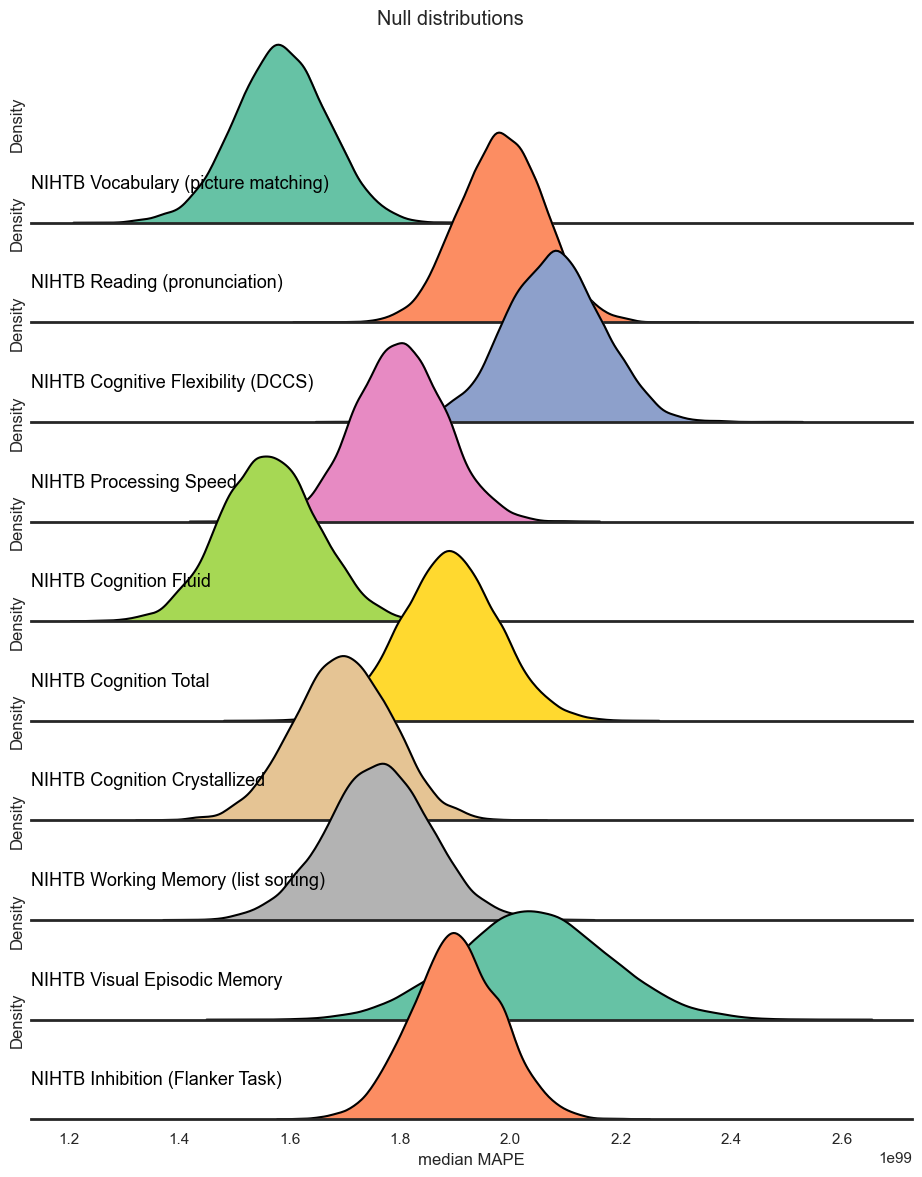

In [83]:
domain = "cog"

if domain == "cog":
    perm_df = perm_baseline_cog
else: 
    perm_df = perm_baseline_psy

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(perm_df[perm_df["seed"]==54], palette=palette, row="target", hue="target", aspect=8, height=1.2)
g.map_dataframe(sns.kdeplot, x=error, fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x=error, color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "target")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="median MAPE")
g.despine( left=True)
plt.suptitle('Null distributions', y=0.98)

In [29]:
predictions

,train_ratio,seed,dataset,PicVocab_AgeAdj,ReadEng_AgeAdj,CogFluidComp_AgeAdj,CogTotalComp_AgeAdj,CogCrystalComp_AgeAdj,CardSort_AgeAdj,ListSort_AgeAdj,...,PicVocab_AgeAdj_pred,ReadEng_AgeAdj_pred,CogFluidComp_AgeAdj_pred,CogTotalComp_AgeAdj_pred,CogCrystalComp_AgeAdj_pred,CardSort_AgeAdj_pred,ListSort_AgeAdj_pred,ProcSpeed_AgeAdj_pred,PicSeq_AgeAdj_pred,Flanker_AgeAdj_pred
0,1.0,42,train,0.436012,0.758682,0.643351,0.700489,0.578466,0.782300,0.464405,...,-0.050902,-0.083725,0.082264,-0.012498,0.094538,0.078539,0.026256,0.038720,-0.007074,-0.007862
1,1.0,42,train,0.355299,0.415369,0.887869,0.749840,0.311377,0.934320,0.650860,...,-0.044174,-0.082959,0.070243,-0.016255,0.092650,0.065849,0.045250,0.032663,-0.006441,-0.011446
2,1.0,42,train,0.561696,0.772871,0.685176,0.798979,0.649644,0.697194,0.538319,...,-0.055918,-0.071632,0.073683,-0.020739,0.087765,0.080704,0.021158,0.036328,0.001406,-0.005448
3,1.0,42,train,0.245595,0.581795,0.423379,0.408317,0.350808,0.756707,0.526681,...,-0.020503,-0.095509,0.072498,-0.025213,0.112271,0.081672,0.034520,0.039279,-0.013715,0.001350
4,1.0,42,train,0.502609,0.679172,0.377622,0.529355,0.561180,0.428153,0.665594,...,-0.030943,-0.088558,0.060772,-0.031561,0.113686,0.090182,0.018040,0.036721,-0.004222,-0.009458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10115,1.0,340,test,0.359233,0.364526,0.505841,0.427356,0.308530,0.593895,0.887582,...,0.109379,0.009653,-0.054507,-0.035122,0.052410,0.059487,-0.055807,0.026941,-0.041119,-0.007800
10116,1.0,340,test,0.526869,0.462627,0.268314,0.361731,0.481231,0.272283,0.650860,...,0.117539,0.004715,-0.061088,-0.043887,0.060349,0.072296,-0.048271,0.031223,-0.040888,0.004515
10117,1.0,340,test,0.370600,0.242182,0.606717,0.452031,0.240893,0.659829,0.650860,...,0.114638,0.010488,-0.079950,-0.042423,0.059036,0.076131,-0.038662,0.035854,-0.048873,0.002002
10118,1.0,340,test,0.544477,0.480761,0.632757,0.657413,0.497446,0.547985,0.718707,...,0.116038,0.015460,-0.047494,-0.044801,0.055995,0.064939,-0.045965,0.036427,-0.032893,-0.002171


In [30]:
predictions.columns

Index(['train_ratio', 'seed', 'dataset', 'PicVocab_AgeAdj', 'ReadEng_AgeAdj',
       'CogFluidComp_AgeAdj', 'CogTotalComp_AgeAdj', 'CogCrystalComp_AgeAdj',
       'CardSort_AgeAdj', 'ListSort_AgeAdj', 'ProcSpeed_AgeAdj',
       'PicSeq_AgeAdj', 'Flanker_AgeAdj', 'indices', 'PicVocab_AgeAdj_pred',
       'ReadEng_AgeAdj_pred', 'CogFluidComp_AgeAdj_pred',
       'CogTotalComp_AgeAdj_pred', 'CogCrystalComp_AgeAdj_pred',
       'CardSort_AgeAdj_pred', 'ListSort_AgeAdj_pred', 'ProcSpeed_AgeAdj_pred',
       'PicSeq_AgeAdj_pred', 'Flanker_AgeAdj_pred'],
      dtype='object')

In [ ]:
if domain == "cog":
    predictions_long = predictions.melt(id_vars=['seed',
                            'dataset',
                            'indices',
                            ],
                    var_name="target",
                    value_vars=['PicVocab_AgeAdj',
                                'ReadEng_AgeAdj',
                                'CogFluidComp_AgeAdj',
                                'CogTotalComp_AgeAdj',
                                'CogCrystalComp_AgeAdj',
                                'CardSort_AgeAdj',
                                'ListSort_AgeAdj',
                                'ProcSpeed_AgeAdj',
                                'PicSeq_AgeAdj',
                                'Flanker_AgeAdj'])


Text(0.5, 0.98, 'Target distributions')

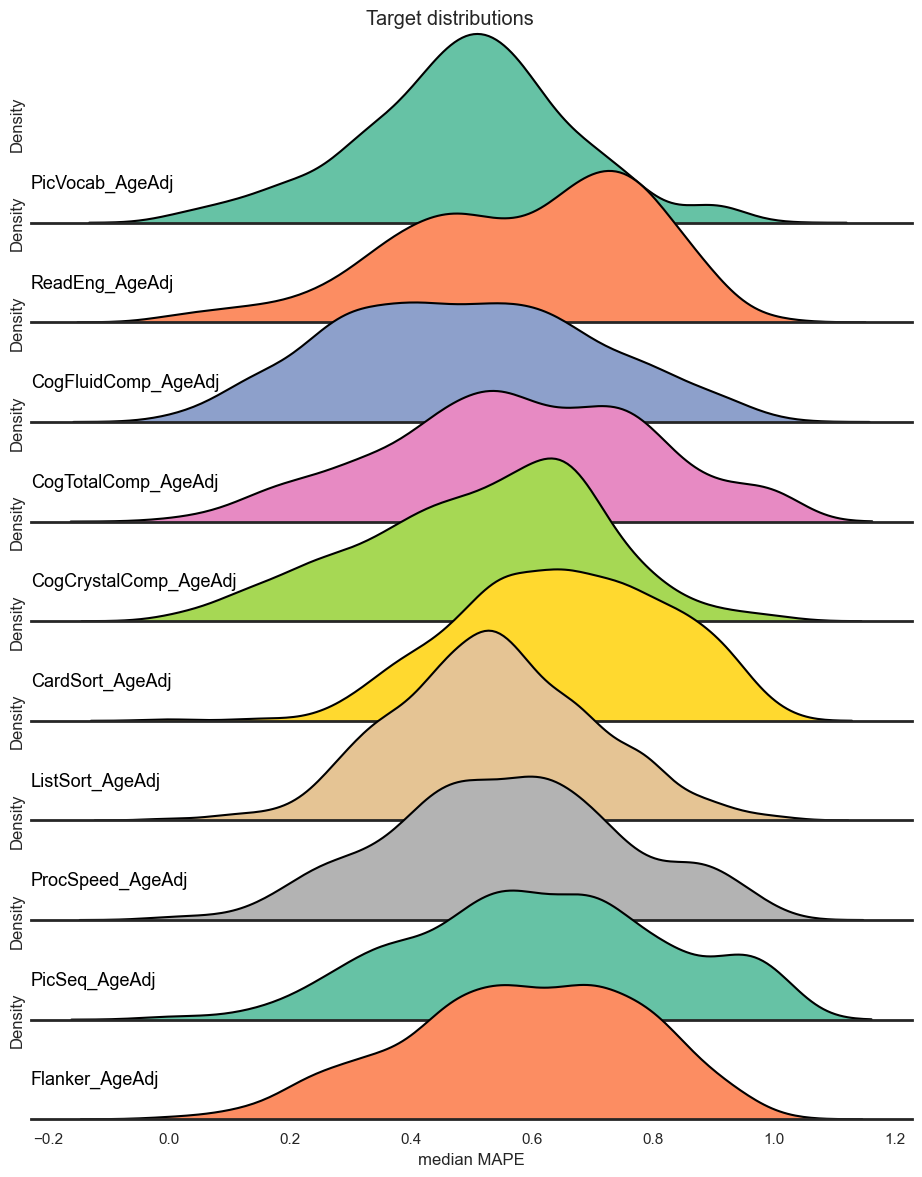

In [34]:

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(predictions_long[predictions_long["seed"]==54], palette=palette, row="target", hue="target", aspect=8, height=1.2)
# g.map_dataframe(sns.kdeplot, x="median_test_mape", fill=True, alpha=1)
# g.map_dataframe(sns.kdeplot, x="median_test_mape", color='black')
g.map_dataframe(sns.kdeplot, x='value', fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x='value', color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "target")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="median MAPE")
g.despine( left=True)
plt.suptitle('Target distributions', y=0.98)

In [119]:
# load perm test
perm_baseline_cog = pd.read_csv(f"results/{exp_name_cog}/perm_test_results/perm_test_results_test{file_suffix}.csv")
perm_baseline_cog_sig = perm_baseline_cog.groupby(["target", "seed"]).agg({'test_corr': sig_level_corr,
                                                              error: sig_level_err}).reset_index()
perm_baseline_cog_mean= perm_baseline_cog.groupby(["target", "seed"]).agg({'test_corr': mean_null_dist,
                                                              error: mean_null_dist}).reset_index()

perm_baseline_psy = pd.read_csv(f"results/{exp_name_psy}/perm_test_results/perm_test_results_test{file_suffix}.csv")
perm_baseline_psy_sig = perm_baseline_psy.groupby(["target", "seed"]).agg({'test_corr': sig_level_corr,
                                                              error: sig_level_corr}).reset_index()
perm_baseline_psy_mean = perm_baseline_psy.groupby(["target", "seed"]).agg({'test_corr': mean_null_dist,
                                                              error: mean_null_dist}).reset_index()

perm_baseline_sig = pd.concat([perm_baseline_cog_sig, perm_baseline_psy_sig])
perm_baseline_sig['target_sorted'] = pd.Categorical(perm_baseline_sig['target'], categories=sorted_targets)
perm_baseline_sig["Feature type"] = "Sig. threshold (alpha = 0.025) across runs"

perm_baseline_mean = pd.concat([perm_baseline_cog_mean, perm_baseline_psy_mean])
perm_baseline_mean['target_sorted'] = pd.Categorical(perm_baseline_mean['target'], categories=sorted_targets)
perm_baseline_mean["Feature type"] = "Null mean across runs"

perm_baseline = pd.concat([perm_baseline_sig, perm_baseline_mean])

# mean_perf_df = perf_df.groupby('target')['test_corr'].mean()
# sorted_targets = mean_perf_df.sort_values(ascending=False).index
# perf_df['target_sorted'] = pd.Categorical(perf_df['target'], categories=sorted_targets)

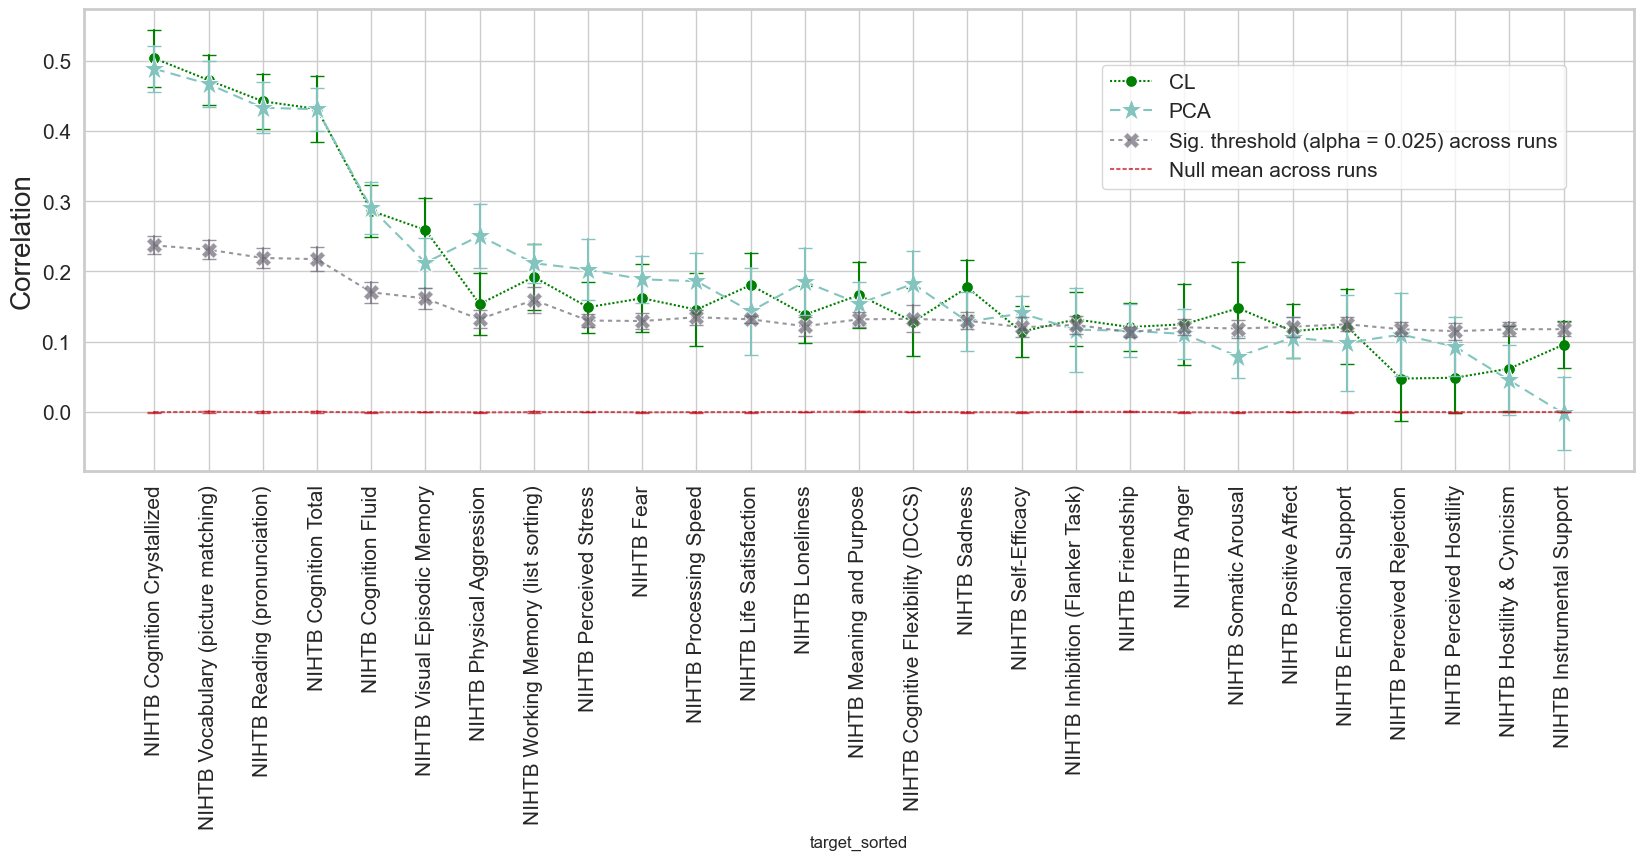

In [121]:
sns.set_style("whitegrid")

markers = {
    "CL": ".",
    "PCA": "*",
    "Sig. threshold (alpha = 0.025) across runs": "X",
    "Null mean across runs": ","
}

colors = {
    "CL": "#008000",
    "PCA": "#83c5be",
    "Sig. threshold (alpha = 0.025) across runs": "#6d6875",
    "Null mean across runs": "#c1121f"
}

dashes = {
    'CL': (1, 1),
    'PCA': (5, 3),
    "Sig. threshold (alpha = 0.025) across runs": (2, 2),
    "Null mean across runs": (2, 1)
    }

fig, ax1 = plt.subplots(figsize=(20, 6))    
ax1 = sns.lineplot(data=perf_df,
                   x="target_sorted",
                   y="test_corr",
                   hue="Feature type",
                   palette=colors,
                #    label="Correlation",
                   err_style="bars",
                   alpha=1.0,
                   style="Feature type",
                   err_kws={'capsize':5},
                   errorbar=("sd", 1),
                   markers=markers,
                   dashes=dashes,
                   markersize=17,
                   legend=True)
plt.xticks(rotation=90, fontsize=15)

sns.lineplot(data=perm_baseline,
             x="target_sorted",
             y="test_corr",
             hue="Feature type",
             palette=colors,
             ax=ax1,
             err_style="bars",
             alpha=0.7,
             style="Feature type",
             err_kws={'capsize':5},
             errorbar=("sd", 1),
             markersize=11,
             markers=markers,
             dashes=dashes,
             )             

ax1.set_ylabel("Correlation", fontsize=20)
# ax2.set_ylabel("Median MAPE (Across Subjects)", fontsize=20)

ax1.tick_params(axis='y', labelsize=15)
# ax2.tick_params(axis='y', labelsize=15)

lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()

# ax2.set_ylim(0, 1)

plt.legend(loc="upper left", bbox_to_anchor=(0.65, 0.80, 1., .102), fontsize=15)
# plt.savefig(f"figures/cl_vs_pca_pred_perf_{dataset_name}_test.png", dpi=300, bbox_inches='tight', format='png')

In [43]:
perm_baseline

,target,seed,test_corr,median_test_mape,target_sorted,Feature type
0,NIHTB Cognition Crystallized,42,0.239110,24.427338,NIHTB Cognition Crystallized,Sig. threshold (alpha = 0.025) across runs
1,NIHTB Cognition Crystallized,54,0.210797,22.929829,NIHTB Cognition Crystallized,Sig. threshold (alpha = 0.025) across runs
2,NIHTB Cognition Crystallized,80,0.260142,23.714595,NIHTB Cognition Crystallized,Sig. threshold (alpha = 0.025) across runs
3,NIHTB Cognition Crystallized,90,0.236755,22.116874,NIHTB Cognition Crystallized,Sig. threshold (alpha = 0.025) across runs
4,NIHTB Cognition Crystallized,101,0.226494,22.026306,NIHTB Cognition Crystallized,Sig. threshold (alpha = 0.025) across runs
...,...,...,...,...,...,...
165,NIHTB Somatic Arousal,128,0.000076,44.608639,NIHTB Somatic Arousal,Null mean across runs
166,NIHTB Somatic Arousal,142,0.000721,51.768210,NIHTB Somatic Arousal,Null mean across runs
167,NIHTB Somatic Arousal,340,-0.002774,40.322148,NIHTB Somatic Arousal,Null mean across runs
168,NIHTB Somatic Arousal,422,0.000309,50.845115,NIHTB Somatic Arousal,Null mean across runs


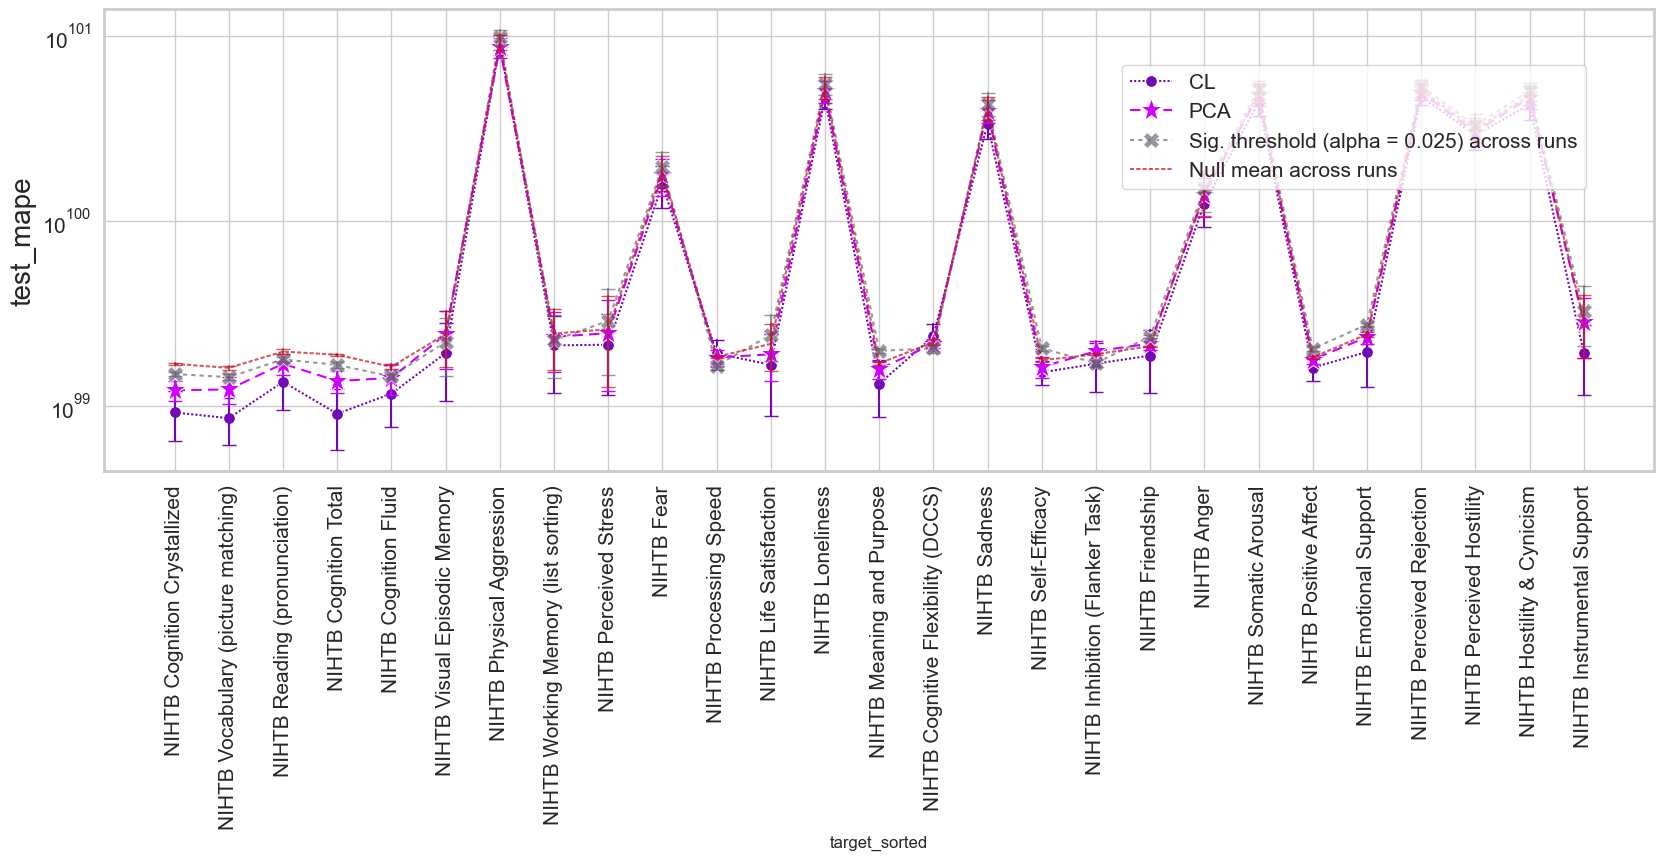

In [123]:
colors = {
    "CL": "#7209b7",
    "PCA": "#CF00FF",
    "Sig. threshold (alpha = 0.025) across runs": "#6d6875",
    "Null mean across runs": "#c1121f"
    
}



fig, ax1 = plt.subplots(figsize=(20, 6))    
ax1 = sns.lineplot(data=perf_df,
                   x="target_sorted",
                   y=error,
                   hue="Feature type",
                   palette=colors,
                   err_style="bars",
                   alpha=1.0,
                   style="Feature type",
                   err_kws={'capsize':5},
                   errorbar=("sd", 1),
                   markers=markers,
                   dashes=dashes,
                   markersize=17,
                   legend=True)
plt.xticks(rotation=90, fontsize=15)

sns.lineplot(data=perm_baseline,
             x="target_sorted",
             y=error,
             hue="Feature type",
             palette=colors,
             ax=ax1,
             err_style="bars",
             alpha=0.7,
             style="Feature type",
             markers=markers,
             markersize=11,
             err_kws={'capsize':5},
             errorbar=("sd", 1),
             dashes=dashes,
             )

ax1.set_ylabel(error, fontsize=20)
# ax2.set_ylabel("Median MAPE (Across Subjects)", fontsize=20)

ax1.tick_params(axis='y', labelsize=15)
# ax2.tick_params(axis='y', labelsize=15)
ax1.set(yscale='log')
lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()

# ax2.set_ylim(0, 1)

plt.legend(loc="upper left", bbox_to_anchor=(0.65, 0.80, 1., .102), fontsize=15)

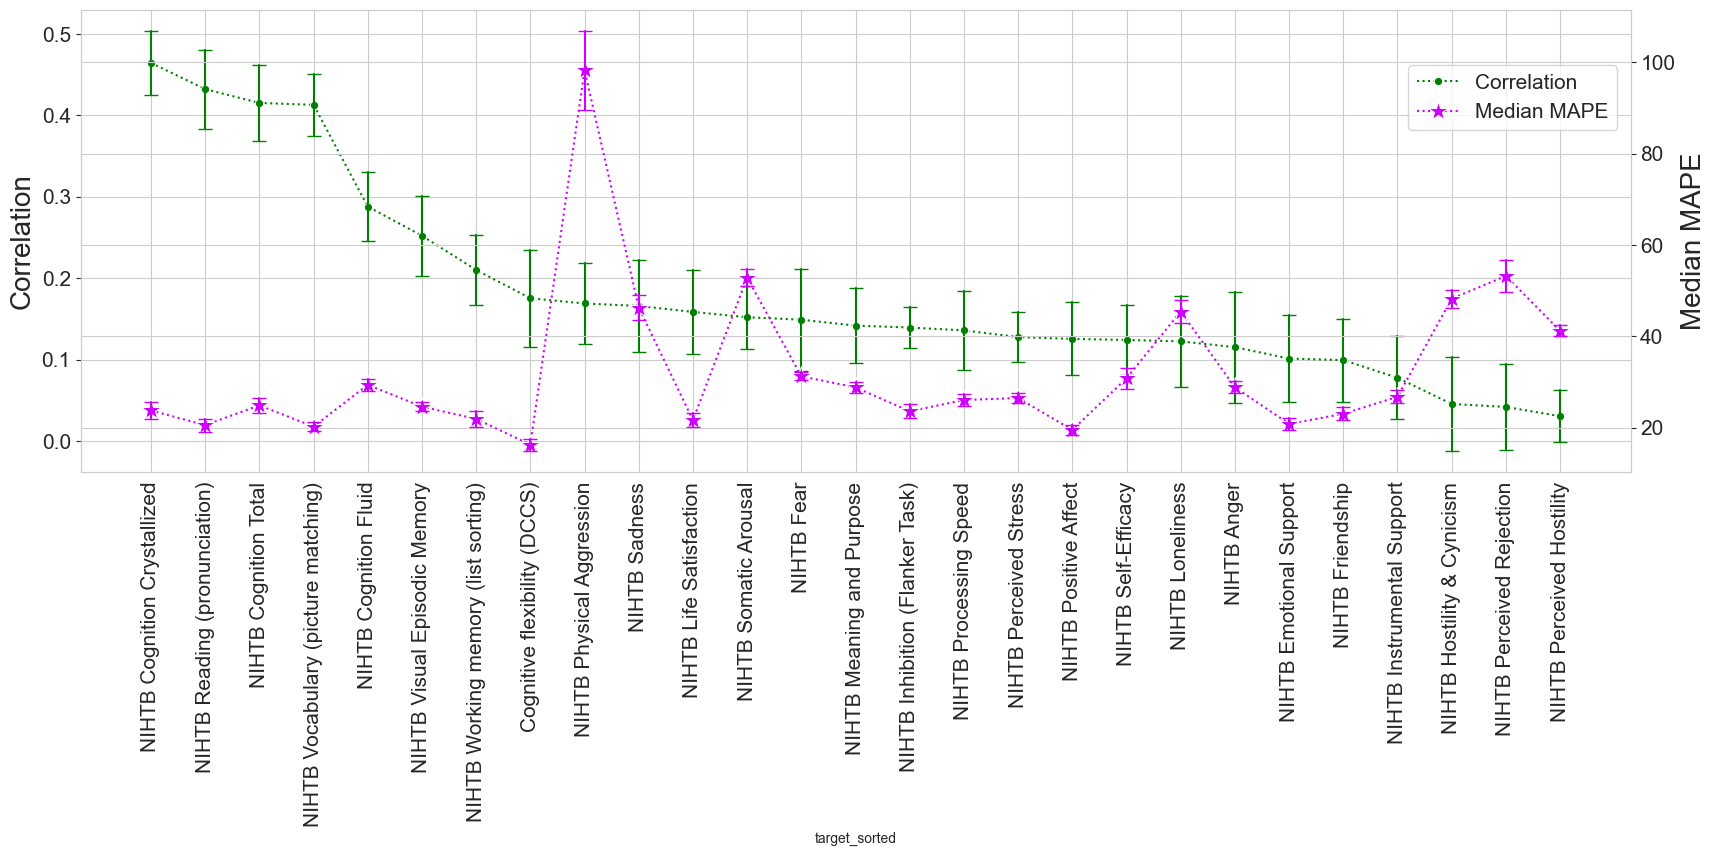

In [41]:
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(20, 6))    
ax1 = sns.lineplot(data=perf_df,
                   x="target_sorted",
                   y="test_corr",
                   color="g",
                   label="Correlation",
                   err_style="bars",
                   marker="o",
                   err_kws={'capsize':5},
                   errorbar=("sd", 1),
                    linestyle='dotted',
                   legend=False)
plt.xticks(rotation=90, fontsize=15)
ax2 = ax1.twinx()
sns.lineplot(data=perf_df,
             x="target_sorted",
             y="median_test_mape",
             ax=ax2,
             color="#CF00FF",
             err_style="bars",
             marker="*",
             errorbar=("sd", 1),
             err_kws={'capsize':5},
             markersize=15,
             linestyle='dotted',
             label="Median MAPE")

ax1.set_ylabel("Correlation", fontsize=20)
ax2.set_ylabel("Median MAPE", fontsize=20)

ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", bbox_to_anchor=(0.85, 0.80, 1., .102), fontsize=15)

In [191]:
y_train = predictions[(predictions["dataset"] == "train") & (predictions["train_ratio"] == train_ratio) & (predictions[run_type] == run_id)][target].values
y_test = predictions[(predictions["dataset"] == test_type) & (predictions["train_ratio"] == train_ratio) & (predictions[run_type] == run_id)][target].values

ridge_estimator = Ridge(alpha=1)
fitted_ridge = ridge_estimator.fit(X_train, y_train)
y_train_pred = fitted_ridge.predict(X_train)
y_test_pred = fitted_ridge.predict(X_test)

KeyError: 'ER40FEAR'

In [25]:
np.save(f"{exp_dir}/ridge_y_pred_train_{target}_{run_type}_{run_id}.npy", y_train_pred)
np.save(f"{exp_dir}/ridge_y_pred_test_{target}_{run_type}_{run_id}.npy", y_test_pred)

### Baseline: Train on all FC edges

In [194]:
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])


In [195]:
dataset_name = "hcp"
domain = "cog"
mode = "shuffle"
prediction_type = "multivar"

In [196]:
if dataset_name == "hcp":
    target_dict = target_dict_hcp
else:
    target_dict = target_dict_abcd
    
dataset_path = f"data/{dataset_name}_400parcels.nc"


if mode =="cv":
    exp_name = f"5foldcv_redmat_enc_{dataset_name}_{prediction_type}_{domain}"
    test_type = "validation"
    run_type = "fold"
    runs = np.arange(5)
else:
    exp_name = f"shuffle_redmat_enc_{dataset_name}_{prediction_type}_{domain}"
    test_type = "test"
    run_type = "seed"
    runs = [1001, 42, 54, 90, 101, 80, 422, 142, 128, 340]


root = '.'
exp_dir = f"{root}/results/{exp_name}"
predictions = pd.read_csv(f'{exp_dir}/pred_results.csv')

dataset = xr.open_dataset(dataset_path)

In [197]:
ridge_runs = []

        
for run_id in tqdm(runs):
    print(f"Run {run_id}")
    X_train_idx = np.load(f"{exp_dir}/train_idx_{run_type}{run_id}_train_ratio{train_ratio}.npy")
    X_test_idx = np.load(f"{exp_dir}/test_idx_{run_type}{run_id}_train_ratio{train_ratio}.npy")

    X_train = dataset.isel(index=X_train_idx).matrices.values
    X_train = sym_matrix_to_vec(X_train)

    X_test = dataset.isel(index=X_test_idx).matrices.values
    X_test = sym_matrix_to_vec(X_test)

    for target in tqdm(target_dict.keys()):
        if target in predictions.columns:
            print(f"Target {target}")
            
            target_run_perf = {}
            y_train = predictions[(predictions["dataset"] == "train") & (predictions["train_ratio"] == 1.0) & (predictions[run_type] == run_id)][target].values
            y_test = predictions[(predictions["dataset"] == "test") & (predictions["train_ratio"] == 1.0) & (predictions[run_type] == run_id)][target].values


            ridge_fitted = ridge_pipeline.fit(X_train, y_train)
            y_train_pred = ridge_fitted.predict(X_train)
            y_test_pred = ridge_fitted.predict(X_test)

            train_corr = custom_corr(y_train, y_train_pred)
            test_corr = custom_corr(y_test, y_test_pred)

            target_run_perf["target"] = target_dict[target]
            target_run_perf["train_corr"] = train_corr
            target_run_perf["test_corr"] = test_corr
            target_run_perf["median_train_mape"] = np.median(100*np.abs(y_train-y_train_pred)/y_train)
            target_run_perf["median_test_mape"] = np.median(100*np.abs(y_test-y_test_pred)/y_test)
            target_run_perf["train_ratio"] = train_ratio
            target_run_perf[run_type] = run_id

            ridge_runs.append(target_run_perf)
ridge_runs_df = pd.DataFrame(ridge_runs)
ridge_runs_df.to_csv(f"{exp_dir}/baseline_ridge_model_perf_runs.csv", index=False)


  0%|          | 0/10 [00:00<?, ?it/s]

Run 1001


Target PicVocab_AgeAdj


Target ReadEng_AgeAdj


Target CardSort_AgeAdj


Target ProcSpeed_AgeAdj


Target CogFluidComp_AgeAdj


Target CogTotalComp_AgeAdj


Target CogCrystalComp_AgeAdj


Target ListSort_AgeAdj


Target PicSeq_AgeAdj


Target Flanker_AgeAdj


 10%|█         | 1/10 [00:06<00:58,  6.50s/it]

Run 42


Target PicVocab_AgeAdj


Target ReadEng_AgeAdj


Target CardSort_AgeAdj


Target ProcSpeed_AgeAdj


Target CogFluidComp_AgeAdj


Target CogTotalComp_AgeAdj


Target CogCrystalComp_AgeAdj


Target ListSort_AgeAdj


Target PicSeq_AgeAdj


Target Flanker_AgeAdj


 20%|██        | 2/10 [00:13<00:52,  6.52s/it]

Run 54


Target PicVocab_AgeAdj


Target ReadEng_AgeAdj


Target CardSort_AgeAdj


Target ProcSpeed_AgeAdj


Target CogFluidComp_AgeAdj


Target CogTotalComp_AgeAdj


Target CogCrystalComp_AgeAdj


Target ListSort_AgeAdj


Target PicSeq_AgeAdj


Target Flanker_AgeAdj


 30%|███       | 3/10 [00:19<00:45,  6.46s/it]

Run 90


Target PicVocab_AgeAdj


Target ReadEng_AgeAdj


Target CardSort_AgeAdj


Target ProcSpeed_AgeAdj


Target CogFluidComp_AgeAdj


Target CogTotalComp_AgeAdj


Target CogCrystalComp_AgeAdj


Target ListSort_AgeAdj


Target PicSeq_AgeAdj


Target Flanker_AgeAdj


 40%|████      | 4/10 [00:25<00:38,  6.40s/it]

Run 101


Target PicVocab_AgeAdj


Target ReadEng_AgeAdj


Target CardSort_AgeAdj


Target ProcSpeed_AgeAdj


Target CogFluidComp_AgeAdj


Target CogTotalComp_AgeAdj


Target CogCrystalComp_AgeAdj


Target ListSort_AgeAdj


Target PicSeq_AgeAdj


Target Flanker_AgeAdj


 50%|█████     | 5/10 [00:32<00:31,  6.39s/it]

Run 80


Target PicVocab_AgeAdj


Target ReadEng_AgeAdj


Target CardSort_AgeAdj


Target ProcSpeed_AgeAdj


Target CogFluidComp_AgeAdj


Target CogTotalComp_AgeAdj


Target CogCrystalComp_AgeAdj


Target ListSort_AgeAdj


Target PicSeq_AgeAdj


Target Flanker_AgeAdj


 60%|██████    | 6/10 [00:38<00:25,  6.37s/it]

Run 422


Target PicVocab_AgeAdj


Target ReadEng_AgeAdj


Target CardSort_AgeAdj


Target ProcSpeed_AgeAdj


Target CogFluidComp_AgeAdj


Target CogTotalComp_AgeAdj


Target CogCrystalComp_AgeAdj


Target ListSort_AgeAdj


Target PicSeq_AgeAdj


Target Flanker_AgeAdj


 70%|███████   | 7/10 [00:44<00:19,  6.35s/it]

Run 142


Target PicVocab_AgeAdj


Target ReadEng_AgeAdj


Target CardSort_AgeAdj


Target ProcSpeed_AgeAdj


Target CogFluidComp_AgeAdj


Target CogTotalComp_AgeAdj


Target CogCrystalComp_AgeAdj


Target ListSort_AgeAdj


Target PicSeq_AgeAdj


Target Flanker_AgeAdj


 80%|████████  | 8/10 [00:51<00:12,  6.34s/it]

Run 128


Target PicVocab_AgeAdj


Target ReadEng_AgeAdj


Target CardSort_AgeAdj


Target ProcSpeed_AgeAdj


Target CogFluidComp_AgeAdj


Target CogTotalComp_AgeAdj


Target CogCrystalComp_AgeAdj


Target ListSort_AgeAdj


Target PicSeq_AgeAdj


Target Flanker_AgeAdj


 90%|█████████ | 9/10 [00:57<00:06,  6.34s/it]

Run 340


Target PicVocab_AgeAdj


Target ReadEng_AgeAdj


Target CardSort_AgeAdj


Target ProcSpeed_AgeAdj


Target CogFluidComp_AgeAdj


Target CogTotalComp_AgeAdj


Target CogCrystalComp_AgeAdj


Target ListSort_AgeAdj


Target PicSeq_AgeAdj


Target Flanker_AgeAdj


100%|██████████| 10/10 [01:04<00:00,  6.44s/it]


In [198]:
ridge_runs_df

,target,train_corr,test_corr,median_train_mape,median_test_mape,train_ratio,seed
0,NIHTB Vocabulary (picture matching),1.0,0.482268,0.000487,20.486639,1.0,1001
1,NIHTB Reading (pronunciation),1.0,0.480757,0.000483,23.556457,1.0,1001
2,NIHTB Cognitive Flexibility (DCCS),1.0,0.198321,0.000429,19.918928,1.0,1001
3,NIHTB Processing Speed,1.0,0.132809,0.000646,29.629488,1.0,1001
4,NIHTB Cognition Fluid,1.0,0.327736,0.000661,32.776088,1.0,1001
...,...,...,...,...,...,...,...
95,NIHTB Cognition Total,1.0,0.504446,0.000683,23.969005,1.0,340
96,NIHTB Cognition Crystallized,1.0,0.543616,0.000541,22.506908,1.0,340
97,NIHTB Working Memory (list sorting),1.0,0.143772,0.000539,23.221533,1.0,340
98,NIHTB Visual Episodic Memory,1.0,0.231853,0.000578,22.200976,1.0,340


In [199]:
dataset_name = "hcp"
exp_name_cog = f"{mode}_redmat_enc_{dataset_name}_{prediction_type}_cog"
exp_name_psy = f"{mode}_redmat_enc_{dataset_name}_{prediction_type}_psy"
perf_cog = pd.read_csv(f"results/{exp_name_cog}/baseline_ridge_model_perf_runs.csv")
perf_psy = pd.read_csv(f"results/{exp_name_psy}/baseline_ridge_model_perf_runs.csv")

perf_df = pd.concat([perf_cog, perf_psy])
# perf_df["median_test_mape"].replace([np.inf, -np.inf], 100, inplace=True)
# perf_df["median_train_mape"].replace([np.inf, -np.inf], 100, inplace=True)

mean_perf_df = perf_df.groupby('target')['test_corr'].mean()
sorted_targets = mean_perf_df.sort_values(ascending=False).index
perf_df['target_sorted'] = pd.Categorical(perf_df['target'], categories=sorted_targets)

In [177]:
perf_df[perf_df["target"] == "NIHTB Cognition Crystallized"]["test_corr"].mean()

0.34613936877191376

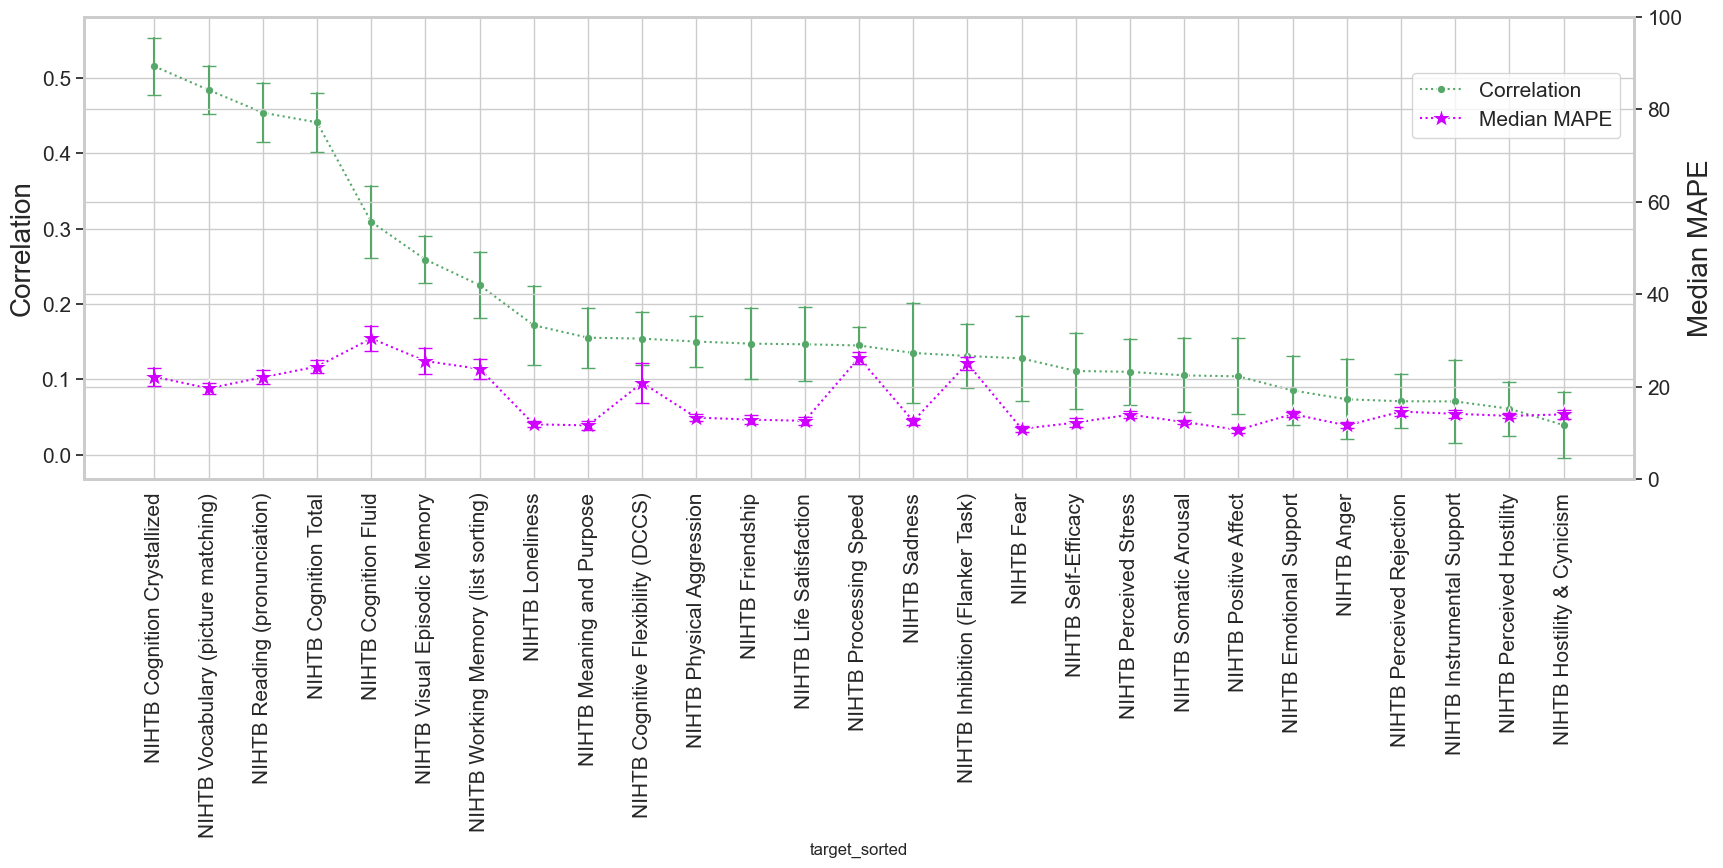

In [200]:
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(20, 6))    
ax1 = sns.lineplot(data=perf_df,
                   x="target_sorted",
                   y="test_corr",
                   color="g",
                   label="Correlation",
                   err_style="bars",
                   marker="o",
                   err_kws={'capsize':5},
                   errorbar=("sd", 1),
                    linestyle='dotted',
                   legend=False)
plt.xticks(rotation=90, fontsize=15)
ax2 = ax1.twinx()
sns.lineplot(data=perf_df,
             x="target_sorted",
             y="median_test_mape",
             ax=ax2,
             color="#CF00FF",
             err_style="bars",
             marker="*",
             errorbar=("sd", 1),
             err_kws={'capsize':5},
             markersize=15,
             linestyle='dotted',
             label="Median MAPE")

ax1.set_ylabel("Correlation", fontsize=20)
ax2.set_ylabel("Median MAPE", fontsize=20)

ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

ax2.set_ylim(0, 100)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", bbox_to_anchor=(0.85, 0.80, 1., .102), fontsize=15)
# plt.savefig(f"figures/baseline_ridge_perf_{dataset_name}_test.svg", dpi=300, bbox_inches='tight', format='svg')

In [22]:
custom_corr(y_test, y_test_pred)

0.3756851855291548

In [23]:
custom_corr(y_train, y_train_pred)

0.7829681210685571

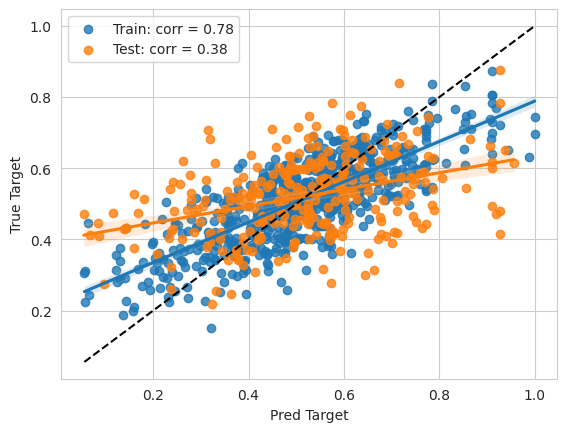

In [24]:
train_corr = custom_corr(y_train, y_train_pred)
test_corr = custom_corr(y_test, y_test_pred)

sns.regplot(x=y_train, y=y_train_pred, label=f"Train: corr = {train_corr:.2f}")
sns.regplot(x=y_test, y=y_test_pred, label=f"Test: corr = {test_corr:.2f}")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], linestyle='--', c='black')
plt.ylabel("True Target")
plt.xlabel("Pred Target")
plt.legend()
plt.show()

Text(0.5, 0, '')

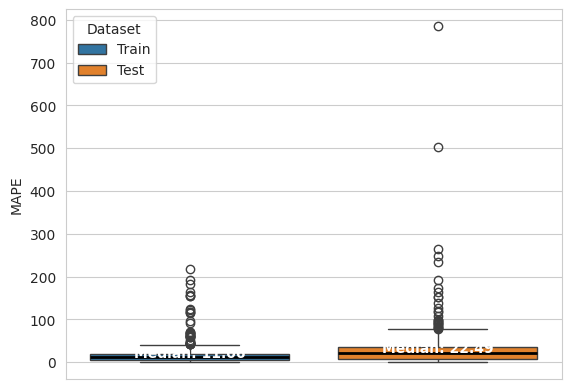

In [129]:
mape_df = pd.DataFrame({
    "sub_id": np.concat([sub_idx_train, sub_idx_test]),
    "dataset": ["Train"]*len(sub_idx_train) + ["Test"]*len(sub_idx_test),
    "MAPE": np.concat([100*np.abs(y_train-y_train_pred)/y_train, 100*np.abs(y_test-y_test_pred)/y_test])
})
median_mape_train = np.median(100*np.abs(y_train-y_train_pred)/y_train)
median_mape_test = np.median(100*np.abs(y_test-y_test_pred)/y_test)

sns.set_style("whitegrid")
sns.boxplot(data=mape_df, x='dataset', y='MAPE', hue='dataset',
            legend=True,
            medianprops={"color": "black", "linewidth": 2}
              )
plt.text(0, median_mape_train + 0.5, f'Median: {median_mape_train:.2f}', horizontalalignment='center', size='medium', color='white', weight='semibold')
plt.text(1, median_mape_test+ 0.5, f'Median: {median_mape_test:.2f}', horizontalalignment='center', size='medium', color='white', weight='semibold')
plt.xticks([], [])
# plt.ylim(-.05, 1.05)
plt.legend(title='Dataset', loc='upper left')
plt.xlabel('Value')
plt.xlabel('')


Text(0.5, 1.0, 'MAPE Test')

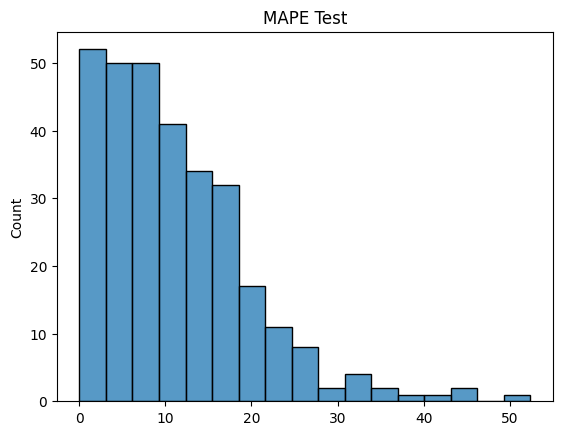

In [184]:
sns.histplot(x=100*np.abs(y_test-y_test_pred)/y_test)
plt.title("MAPE Test")

<Axes: xlabel='Mean of x and y', ylabel='x - y'>

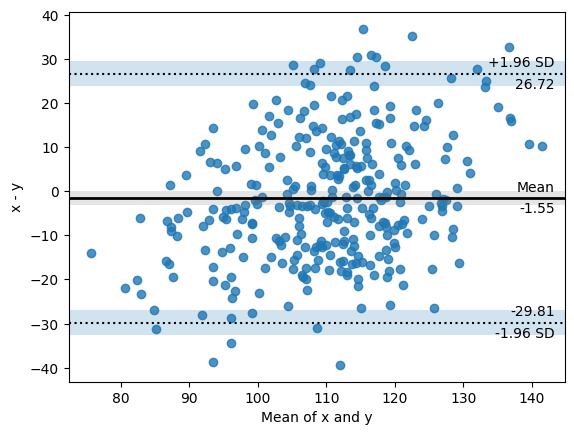

In [185]:
pg.plot_blandaltman(y_test, y_test_pred)